# Titanic Dataset - EDA, Feature Preprocessing, PCA

# EDA

EDA (Exploratory Data Analysis) is an initial step in the data analysis process that involves summarizing, visualizing, and analyzing datasets to gain insights, identify patterns, trends, and anomalies, and form hypotheses before applying more advanced statistical or machine learning techniques. 

EDA helps in understanding the underlying structure of the data, assessing data quality, and identifying the most important variables or features for further analysis or modeling. It is an essential step in the data science workflow to make informed decisions and build effective models.

**Note:** This is not a streamlined analysis, but it contains certain redundancies with the purpose of featuring and exploring different visualisation and modelling tools that can be useful in approaching a binary classification problem.

Special thanks to user https://heads0rtai1s.github.io/ for his Pytanic investigation on which this whole laboratory is based.


## Outline:
1. Load Data and Modules
2. Initial Exploration
3. Relations between features
4. Missing values
5. Derived (engineered) features
6. Preparing for modelling
7. Modelling (& PCA)

# **1. Load Data and Modules**

**Load Python modules:** The list of modules grows step by step by adding new functionality that is useful for this project. A module could be defined further down once it is needed, but the majority of the used ones have been defined here.

In [1]:
#%matplotlib inline

# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

sns.set(style='white', context='notebook', palette='deep')

**Load input data.** And combine the available features of train and test data sets. *test* of course doesn't have the column that indicates survival.

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
combine = pd.concat([train.drop('Survived',1),test])

# 2. Initial Exploration

**Look at your data in as many different ways as possible.** Some properties and connections will be immediately obvious. Others will require you to examine the data, or parts of it, in more specific ways. Metaphorically speaking: this is the part where the detective finds the clues.

First a broad overview. What are the types of data and their typical shape and content?

In [3]:
train.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


Together with the PassengerId which is just a running index and the indication whether this passenger survived (1) or not (0) we have the following information for each person:

- *Pclass* is the Ticket-class: first (1), second (2), and third (3) class tickets were used. This is an ordinal integer feature. 

- *Name* is the name of the passenger. The names also contain titles and some persons might share the same surname; indicating family relations. We know that some titles can indicate a certain age group. For instance *Master* is a boy while *Mr* is a man. This feature is a character string of variable length but similar format.

- *Sex* is an indicator whether the passenger was female or male. This is a categorical text string feature. 

- *Age* is the integer age of the passenger. There are NaN values in this column.

- *SibSp* is another ordinal integer feature describing the number of siblings or spouses travelling with each passenger.

- *Parch* is another ordinal integer features that gives the number of parents or children travelling with each passenger.

- *Ticket* is a character string of variable length that gives the ticket number.

- *Fare* is a float feature showing how much each passenger paid for their rather memorable journey.

- *Cabin* gives the cabin number of each passenger. There are NaN in this column. This is another string feature.

- *Embarked* shows the port of embarkation as a categorical character value.

In summary we have 1 floating point feature (*Fare*), 1 integer variable (*Age*), 3 ordinal integer features (*Plcass, SibSp, Parch*), 2 categorical text features (*Sex, Embarked*), and 3 text string features (*Ticket, Cabin, Name*).

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The minimum/maxim values for pclass, age, sibsp, parch show us the range of these features. Also we see that there's quite a range in fares.

### *Missing values*

In [5]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


Knowing about missing values is important because they indicate how much we don't know about our data.  Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

**We learn:**

- In the **training data** a large majority of *Cabin* numbers are missing, together with 177 *Age* values and 2 *Embarked* values. 

- Also, in the **test** data there is one *Fare* missing (cheeky selection), almost 100 *Age* values are unknown, and only 91 *Cabin* numbers were preserved. Best to keep that in mind.

How many people Survived?

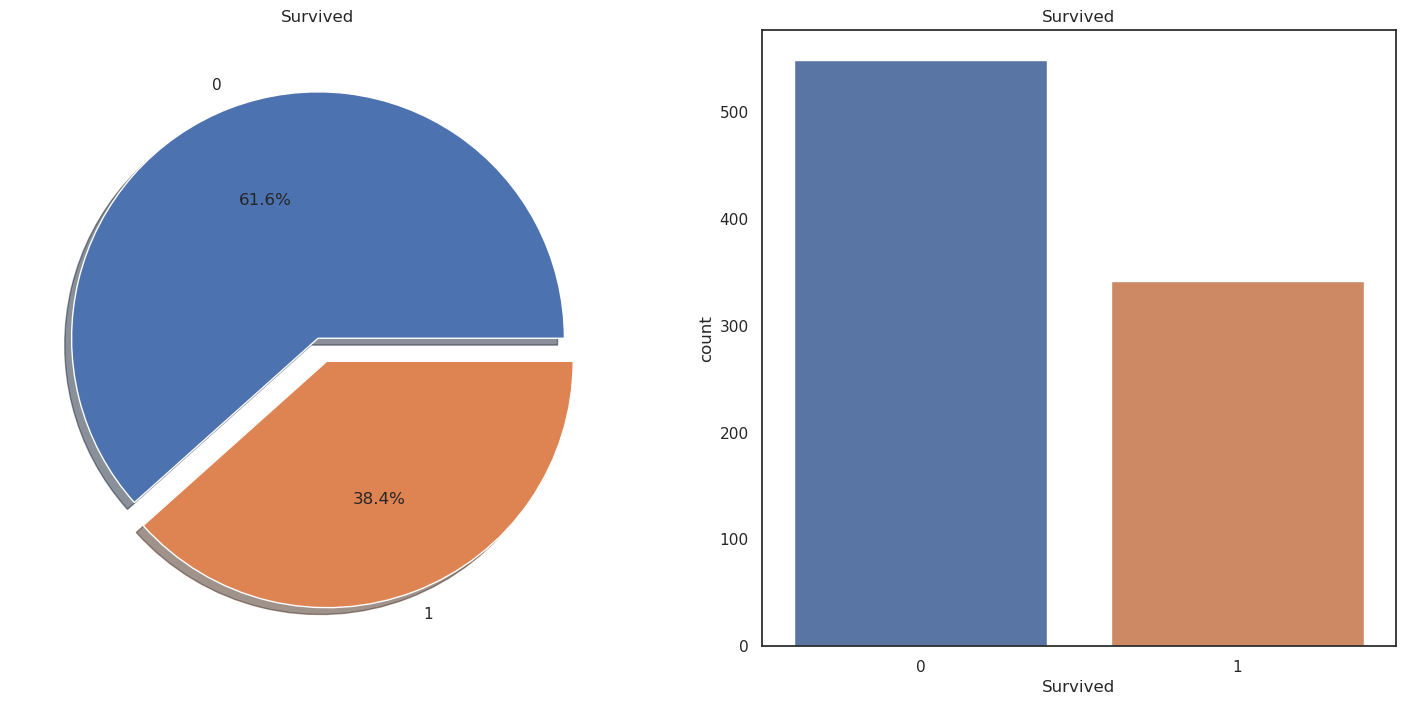

In [7]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')

sns.countplot(x='Survived', data=train, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

In [8]:
print(train['Survived'].sum(), "survived out of", len(train), "total passengers")

342 survived out of 891 total passengers


In our training data set about 60% of the passengers didn't survive. By flat out predicting that everyone in the testing data set died we would get a 60% accuracy. We aim to do better than that.

Here we also define a consistent colour scheme for the distinguishing between survived / not survived. This scheme will (soon) be used throughout this kernel.

# Exercise 1 - done.

Draw a plot (two subplots) showing the survival rates for women and for men.

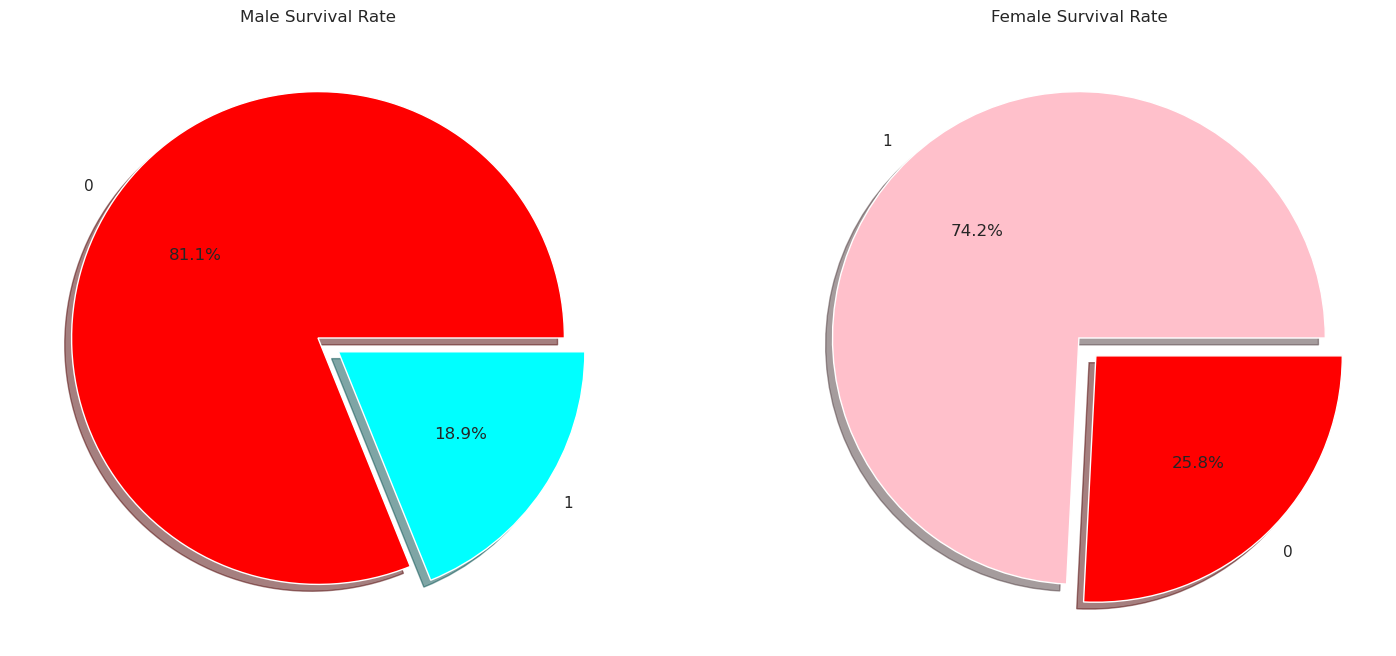

In [9]:
male   =train[train['Sex']=='male']['Survived'].value_counts()
female =train[train['Sex']=='female']['Survived'].value_counts()

f,ax=plt.subplots(1,2,figsize=(18,8))

male.plot.pie(  explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, colors=['red','cyan'])
female.plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[1],shadow=True, colors=['pink','red'])

ax[0].set_title('Male Survival Rate')
ax[1].set_title('Female Survival Rate')

ax[0].set_ylabel('')
ax[1].set_ylabel('')

plt.show()

OK, let's go through the features one by one to see what we find. Here we will see how the distributions of survivors and non-survivors compare. Histograms are useful for a first look at comparing two or more populations in case of scaled features. For categorical features we will use barplots plus standard deviation bars, to better judge the significance.

Median age survivors: 28.0, Median age non-survivers: 28.0


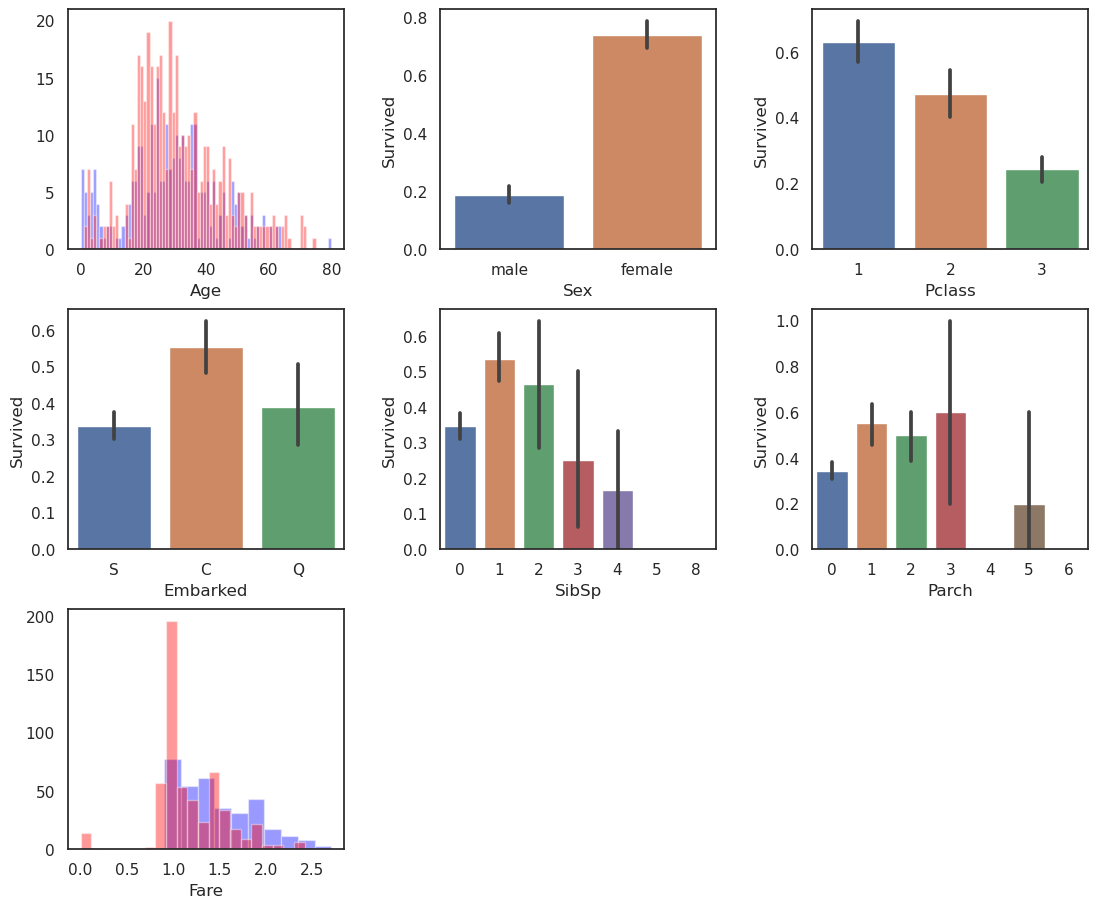

In [10]:
surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]
surv_col = "blue"
nosurv_col = "red"

warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='Age')
plt.subplot(332)
sns.barplot(x='Sex', y='Survived', data=train)
plt.subplot(333)
sns.barplot(x='Pclass', y='Survived', data=train)
plt.subplot(334)
sns.barplot(x='Embarked', y='Survived', data=train)
plt.subplot(335)
sns.barplot(x='SibSp', y='Survived', data=train)
plt.subplot(336)
sns.barplot(x='Parch', y='Survived', data=train)
plt.subplot(337)
sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color=surv_col)
sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

print("Median age survivors: %.1f, Median age non-survivers: %.1f"\
      %(np.median(surv['Age'].dropna()), np.median(nosurv['Age'].dropna())))

Above we are creating a kind of summary dashboard, where we collect relevant visualisations to study the distributions of the individual features. We use the matplotlib *subplot* tool to line up the individual plots in a grid. We use overlapping histograms for ordinal features and barplots for categorical features. The barplots show the fraction of people (per group) who survived. There's a lot going on in this figure, so take your time to look at all the details.

**We learn** the following things from studying the individual features:

- *Age:* The medians are identical. However, it's noticeable that fewer young adults have survived (ages 18 - 30-ish) whereas **children younger than 10-ish had a better survival rate.** Also, there are no obvious outliers that would indicate problematic input data. The highest ages are well consistent with the overall distribution. There is a notable shortage of teenagers compared to the crowd of younger kids. But this could have natural reasons.

- *Pclass:* There's a clear trend that **being a 1st class passenger gives you better chances of survival**. Life just isn't fair.

- *SibSp & Parch:* **Having 1-3 siblings/spouses/parents/children on board (SibSp = 1-2, Parch = 1-3) suggests proportionally better survival numbers than being alone (SibSp + Parch = 0) or having a large family travelling with you.**

- *Embarked:* Well, that does look more interesting than expected.  **Embarking at "C" resulted in a higher survival rate than embarking at "S"**. There might be a correlation with other variables, here though.

- *Fare:* This is case where a linear scaling isn't of much help because there is a smaller number of more extreme numbers. A natural choice in this case is to transform the values logarithmically. For this to work we need to adjust for the zero-fare entries.  The plot tells us that the **survival chances were much lower for the cheaper cabins**. Naively, one would assume that those cheap cabins were mostly located deeper inside the ship, i.e. further away from the life boats.

### *Cabin numbers*

This is a tricky feature because there are so many missing values and the strings don't all have the same number or formatting.

In [11]:
print("We know %i of %i Cabin numbers in the training data set and"
      %(len(train['Cabin'].dropna()), len(train)))
print("we know %i of %i Cabin numbers in the testing data set."
      %(len(test['Cabin'].dropna()), len(test)))
train.loc[:,['Survived','Cabin']].dropna().head(8)

We know 204 of 891 Cabin numbers in the training data set and
we know 91 of 418 Cabin numbers in the testing data set.


,Survived,Cabin
1,1,C85
3,1,C123
6,0,E46
10,1,G6
11,1,C103
21,1,D56
23,1,A6
27,0,C23 C25 C27


**We can try out:**

- I suppose one could take the starting letters, which might indicate specific decks on the ship, and use them as an additional classifier. But for less than 25% of cabins known this might not be very useful. We'll see.

- Also, given that so few cabin numbers are know it doesn't seem that there are good records of them. Therefore, one should assume that it's more likely to know someone's cabin number if they survived. Let's see about that in the derived features.

*TODO: Why do some people have multiple cabin numbers? What does that mean?*

## *Ticket numbers*

That seems to be a hopeless variable at first because it just looks like random strings. But in these days, when you were travelling as a group/family did everyone really get their own ticket? Let's find out how many unique ticket numbers there are:

In [12]:
print("There are %i unique ticket numbers among the %i tickets." \
      %(train['Ticket'].nunique(),train['Ticket'].count()))

There are 681 unique ticket numbers among the 891 tickets.


Interesting. Sharing a ticket number is not uncommon. Let's follow that up a bit.

In [13]:
grouped = train.groupby('Ticket')
k = 0
for name, group in grouped:
    if (len(grouped.get_group(name)) > 1):
        print(group.loc[:,['Survived','Name', 'Fare']])
        k += 1
    if (k>10):
        break

     Survived                                               Name  Fare
257         1                               Cherry, Miss. Gladys  86.5
504         1                              Maioni, Miss. Roberta  86.5
759         1  Rothes, the Countess. of (Lucy Noel Martha Dye...  86.5
     Survived                                    Name   Fare
262         0                       Taussig, Mr. Emil  79.65
558         1  Taussig, Mrs. Emil (Tillie Mandelbaum)  79.65
585         1                     Taussig, Miss. Ruth  79.65
     Survived                            Name  Fare
110         0  Porter, Mr. Walter Chamberlain  52.0
475         0     Clifford, Mr. George Quincy  52.0
     Survived                                             Name     Fare
329         1                     Hippach, Miss. Jean Gertrude  57.9792
523         1  Hippach, Mrs. Louis Albert (Ida Sophia Fischer)  57.9792
     Survived                                    Name  Fare
166         1  Chibnall, Mrs. (Edith Mar

**We can try out:**

Working hypothesis: if your group (mostly family) survived then you survived as well, unless you were a man (and presumably helped your wife/daughter/lady friend). We could go through the trouble here to identify families by last name. However

 1. Common last names might not be unique in the passenger list
 2. As we see above a ticket is not always shared by people with a common name.

Therefore, a shared ticket might actually be a stronger predictor. Of course this assumption should be tested by doing the last-name thing too. In addition, we see that the *Fare* was identical for all the passengers in each ticket group. This is something we will explore in more detail below.

# 3. Relations between features

After inspecting the available features individually you might have realised that some of them are likely to be connected. Does the age-dependent survival change with sex? How are pclass and fare related? Are they strongly enough connected so that one of them is superfluous? Let's find out.

Now we are connecting individual clues to get a glimpse of the bigger picture.

We start with an **overview plot of the feature relations:** Here we show a *correlation matrix* for each numerical variable with all the other numerical variables. We excluded *PassengerID*, which is merely a row index. In the plot, stronger correlations have brighter colours in either red (positive correlation) or blue (negative correlation). The closer to white a colour is the weaker the correlation. 

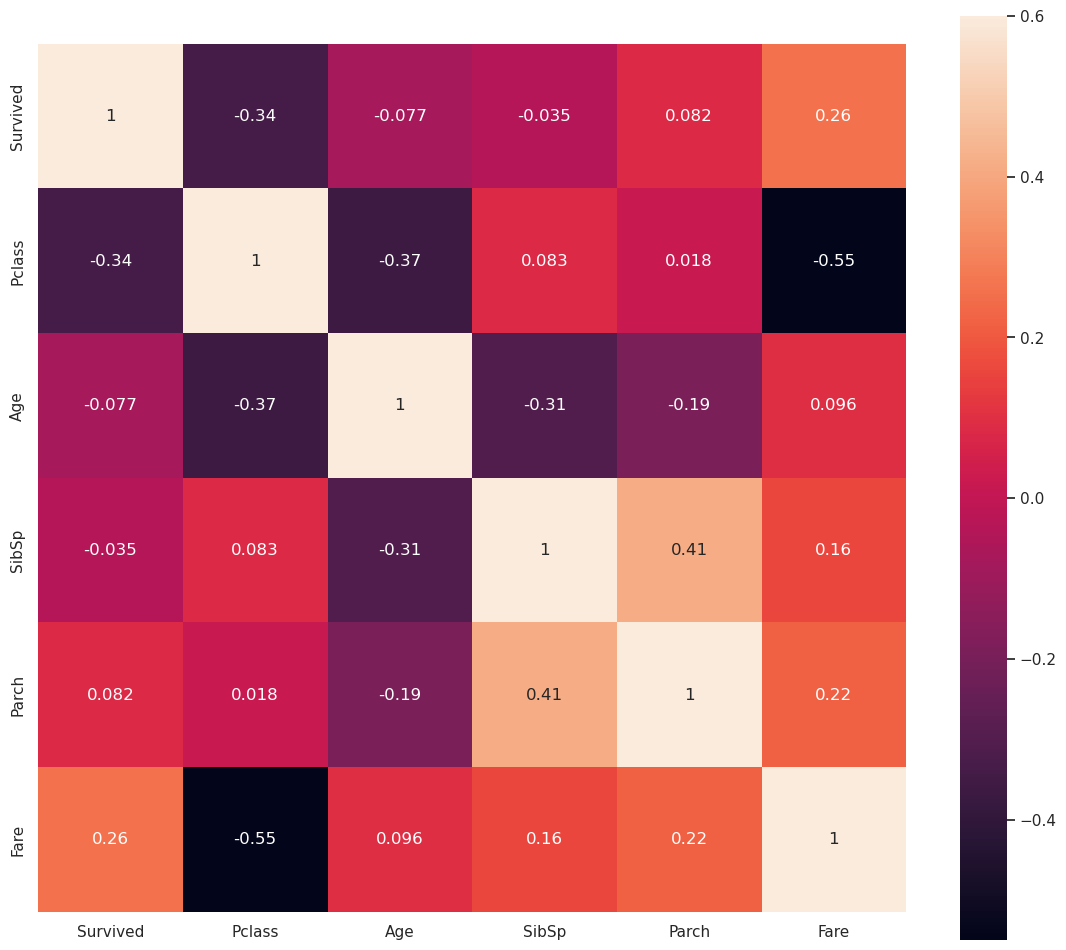

In [14]:
plt.figure(figsize=(14,12))
foo = sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)

*Positive vs negative correlation* needs to be understood in terms of whether an increase in one feature leads to an increase (positive) or decrease (negative) in the correlated feature. Perfect correlation would have a correlation index of 1; perfect anti-correlation (= negative correlation) would have -1 (obviously each feature is perfectly correlated with itself; leading to the deep red diagonal). The upper right vs lower left triangle that make up this plot contain the same information, since the corresponding cells show the correlation coefficients of the same features. 

The matrix gives us an overview as to which features are particularly interesting for our analysis. Both strongly positive or negative correlations with the *Survived* feature are valuable. Strong correlations between two other features would suggest that only one of them is necessary for our model (and including the other would in fact induce noise and potentially lead to over-fitting).

**We learn:**

- *Pclass* is somewhat correlated with *Fare* (1st class tickets would be more expensive than 3rd class ones)
- *SibSp* and *Parch* are weakly correlated (large families would have high values for both; solo travellers would have zero for both)
- *Pclass* already correlates with *Survived* in a noticeable way

In addition, we plot a **Pairplot** of the numerical features. This kind of plot is a more detailed visualisation of relationships between variables. It shows scatter plots for the different feature combinations plus a distribution of each feature on the diagonal. Again, the upper right and lower left triangle contain the same information. This kind of plot is vastly more useful for a set of continuous variables, instead of the categorical or integer values we have here. Nonetheless, it is a valuable exploratory tool that has a place in everyone's toolbox.

This plot is inspired by, and realised much more aesthetically in, the [comprehensive Ensemble Stacking Kernel by Anisotropic](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)  

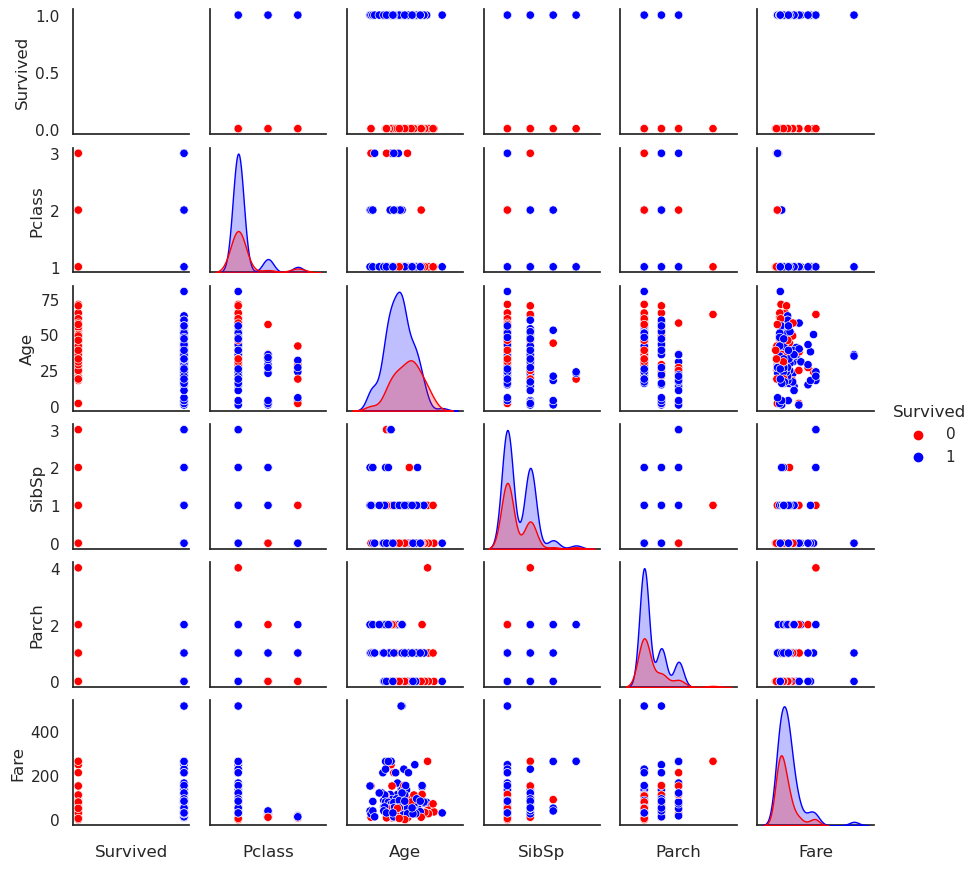

In [15]:
cols = ['Survived','Pclass','Age','SibSp','Parch','Fare']
g = sns.pairplot(data=train.dropna(), vars=cols, size=1.5,
                 hue='Survived', palette=[nosurv_col,surv_col])
g.set(xticklabels=[])

Now we continue to examine these initial indications in more detail. Earlier, we had a look at the *Survived* statistics of the individual features in the overview figure. Here, we want to look at correlations between the predictor features and how they could affect the target *Survived* behaviour.

Usually it's most interesting to start with the strong signals in the correlation plot and to examine them more in detail.

<AxesSubplot:xlabel='Male Age'>

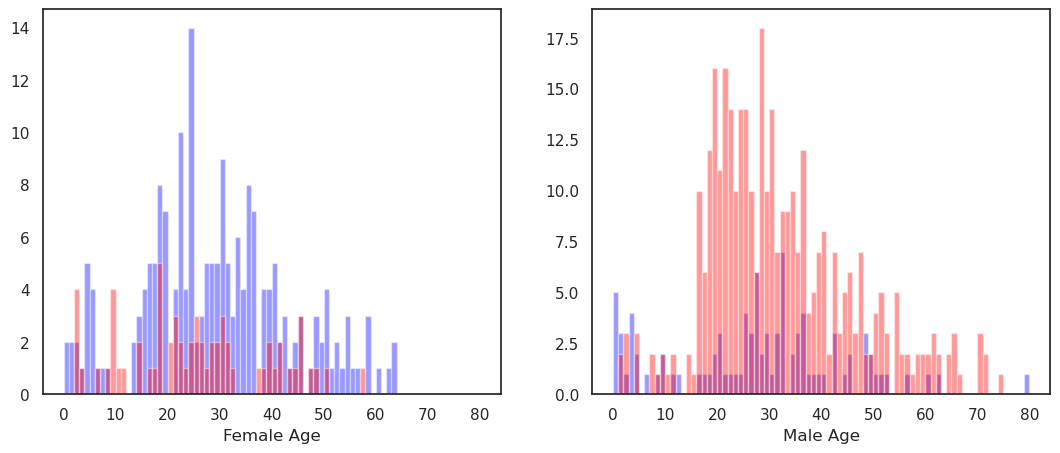

In [16]:
msurv   = train[(train['Survived']==1) & (train['Sex']=="male")]
fsurv   = train[(train['Survived']==1) & (train['Sex']=="female")]
mnosurv = train[(train['Survived']==0) & (train['Sex']=="male")]
fnosurv = train[(train['Survived']==0) & (train['Sex']=="female")]

plt.figure(figsize=[13,5])
plt.subplot(121)
sns.distplot(fsurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(fnosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='Female Age')
plt.subplot(122)
sns.distplot(msurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(mnosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='Male Age')

**We learn:**

- For females the survival chances appear to be higher between 18 and 40, whereas for men in that age range the odds are flipped. This difference between 18-40 yr olds might be a better feature than *Sex* and *Age* by themselves.

- Boys have proportional better survival chances than men, whereas girls have similar chances as women have. Rather small numbers, though. 

We study the correlation of *Age* with *Pclass* using a *violin plot*, which is also split between survived (right half) and not survived (left half). Check out the other visualisations in your forked copy.

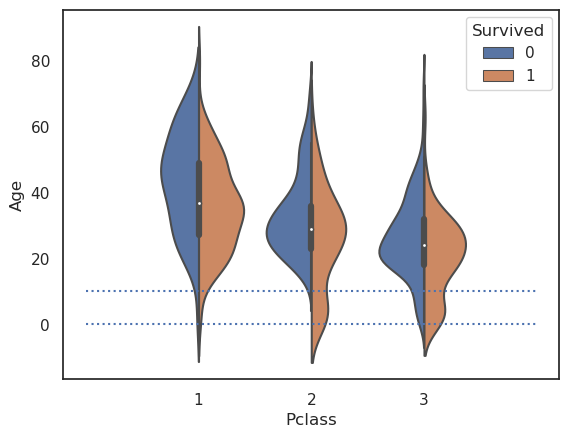

In [17]:
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train, split=True)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles="dotted")

*Violin plots* are a modified version of boxplots, where the shape is a "kernel density estimate" of the underlying distribution. These estimates are smoothed and therefore extend beyond the actual values (look closely at the dotted zero level). I have also indicated *Age == 10*, which we will use to define children (vs teenagers) in the engineering part below.

**We learn:**

- Age decreases progressively as Pclass decreases from 1st to 3rd
- Most older passengers are 1st class, but very few children are. This conflates the impact of *Age* and *Pclass* on the survival chances.
- In 1st class, younger adults had better survival chances than older ones.
- Most children in 2nd class survived, and the majority in 3rd class did too.

# Exercise 2 - done.

Create a plot showing the relation between passenger class and survival rate.


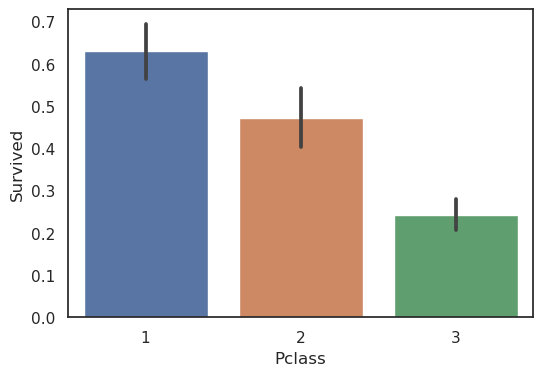

In [18]:
plt.figure(figsize=[6,4])
sns.barplot(x='Pclass', y='Survived', data=train)
plt.show()

Finally, let's check what's going on between *Age* and *Embarked*:

Let's study the relation between *Fare* and *Pclass* in more detail:

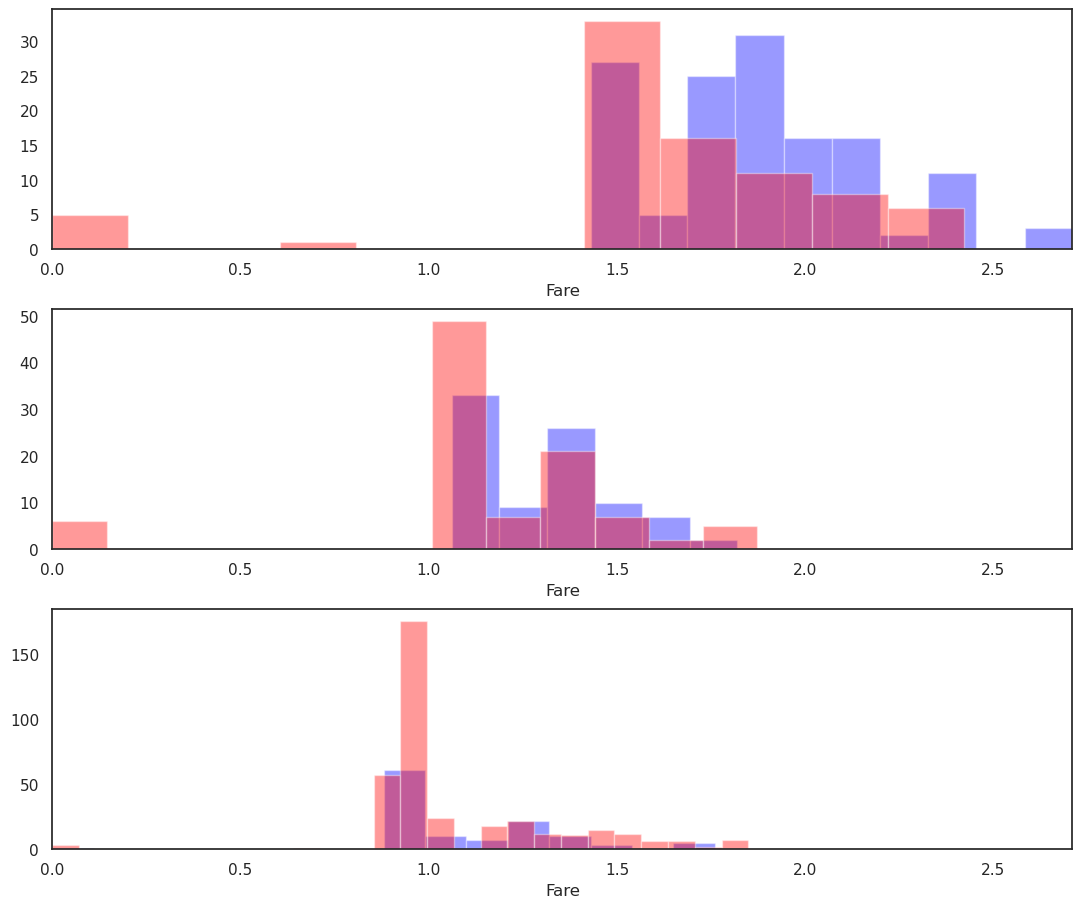

In [19]:
plt.figure(figsize=[12,10])
plt.subplot(311)
ax1 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==1].dropna().values+1), kde=False, color=surv_col)
ax1 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==1].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax1.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values)))
plt.subplot(312)
ax2 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==2].dropna().values+1), kde=False, color=surv_col)
ax2 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==2].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax2.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values)))
plt.subplot(313)
ax3 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==3].dropna().values+1), kde=False, color=surv_col)
ax3 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==3].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax3.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values)))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

**We learn:**

- There is a broad distribution between the 1st class passenger fares (rich -> super rich)
- There's an interesting bimodality in the 2nd class cabins and a long tail in the 3rd class ones. (*TODO: check cumulative fare question*)
- For each class there is strong evidence that the cheaper cabins were worse for survival

# 4. Filling in missing values

After studying the relations between the different features let's fill in a few missing values based on what we learned.

In my opinion, the only training feature for which it makes sense to fill in the NAs is *Embarked*. Too many *Cabin* numbers are missing. And for *Age* we will choose a different approach below. We fill in the 1 missing *Fare* value in the test data frame accordingly.

Let's find the two passengers and assign the most likely port based on what we found so far:

In [20]:
print(train[train['Embarked'].isnull()])

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


These are two women that travelled together in 1st class, were 38 and 62 years old, and had no family on board.

In [21]:
combine.where((combine['Embarked'] !='Q') & (combine['Pclass'] < 1.5) & \
    (combine['Sex'] == "female")).groupby(['Embarked','Pclass','Sex','Parch','SibSp']).size()

Embarked  Pclass  Sex     Parch  SibSp
C         1.0     female  0.0    0.0      30
                                 1.0      20
                          1.0    0.0      10
                                 1.0       6
                          2.0    0.0       2
                                 2.0       2
                          3.0    1.0       1
S         1.0     female  0.0    0.0      20
                                 1.0      20
                                 2.0       3
                          1.0    0.0       7
                                 1.0       6
                          2.0    0.0       4
                                 1.0       5
                                 3.0       3
                          4.0    1.0       1
dtype: int64

Admittedly, these are quite a few grouping levels, but 30 ("C") vs 20 ("S") are numbers that are still large enough to be useful in this context. In addition, already a grouping without the *Parch* and *SibSp* features suggests similar numbers for women in 1st class embarking from "C" (71) vs "S" (69) (in contrast to the larger overall number of all 1st class passengers leaving from "S").

Another recent kernel ([definitely worth checking out](https://www.kaggle.com/varimp/a-mostly-tidyverse-tour-of-the-titanic)) makes a convincing case for predicting *Embarked == "S"* for these two passengers (see also the comments). However, in my opinion we have better reasons to impute "C" instead. I recommend that you weigh the arguments and make your own decision.

*(How much does it actually matter? Well, in the big picture these are only 2 passengers and their impact on our model accuracy won't be large.)*

In [22]:
train['Embarked'].iloc[61] = "C"
train['Embarked'].iloc[829] = "C"

In [23]:
print(test[test['Fare'].isnull()])

     PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  
152   NaN   NaN        S  


In [24]:
print(test[test['Fare'].isnull()])

     PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  
152   NaN   NaN        S  


A 60-yr old 3rd class passenger without family on board. We will base our *Fare* prediction on the median of the 3rd-class fares:

In [25]:
test['Fare'].iloc[152] = combine['Fare'][combine['Pclass'] == 3].dropna().median()
print(test['Fare'].iloc[152])

8.05


As we had seen earlier, the Age feature has 177 null values. To replace these NaN values, one thing we can do is assign them the mean age of the dataset.

The problem is, there were many people with many different ages, we can't just assign a 4 year old child with the mean age that is 29 years. Is there any way we can do better?

Yes! we can check the Name feature. Looking upon the feature, we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups.



# Exercise 3

**Find the average age of the following classes: Master, Miss, Mr, Mrs and Other.**


Hint: Before you can do this, you will need to reassign some other categories to the one you think fits bets out of the 5 above. E.g. Mlle (Mademoiselle) should get assigned to miss.


<a id='derived'></a>

In [26]:
train['Initial']=0
for i in train:
    train['Initial']=train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
train['Initial'].value_counts()

# Write your code below


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Initial, dtype: int64

In [27]:
#train['Initial'] = train['Initial'].replace([], 'Master')
train['Initial'] = train['Initial'].replace(['Mlle', 'Ms', 'Lady', 'Mme'],     'Miss' )
train['Initial'] = train['Initial'].replace(['Sir','Don', 'Jonkheer'],         'Mr'   )
train['Initial'] = train['Initial'].replace(['Countess'],                      'Mrs'  )
train['Initial'] = train['Initial'].replace(['Dr','Rev','Major','Col','Capt'], 'Other')
train['Initial'].value_counts()


Mr        520
Miss      187
Mrs       126
Master     40
Other      18
Name: Initial, dtype: int64

# 5. Engineered features (derived from other features)

The next idea is to define new features based on the existing ones that allow for a split into survived/not-survived with higher confidence than the existing features. An example would be "rich woman" vs "poor man", but this particular distinction should be handled well by most classifiers. We're looking for something a bit more subtle here. This is the part where the detective puts individual clues together to see whether their sum is more than its parts.

This part of the analysis is called *Feature Engineering*. We will list all the new features that we define together in one place, to keep an overview. Every time we can think of a new feature, we come back here to define it and then study it further down. We compute the new features in the combined data set, to make sure that all feature realisations are complete, and then split the combine data again into train and test.

Even with these approximations and deductions, we risk inserting error more than anything. 
For this reason we will instead add a feature called Age_known, providing information on whether the age information is available for current passenger.

In [28]:
combine = pd.concat([train.drop('Survived',1),test])
survived = train['Survived']

combine['Child'] = combine['Age']<=10
combine['Cabin_known'] = combine['Cabin'].isnull() == False
combine['Age_known'] = combine['Age'].isnull() == False
combine['Family'] = combine['SibSp'] + combine['Parch']
combine['Alone']  = (combine['SibSp'] + combine['Parch']) == 0
combine['Large_Family'] = (combine['SibSp']>2) | (combine['Parch']>3)
combine['Deck'] = combine['Cabin'].str[0]
combine['Deck'] = combine['Deck'].fillna(value='U')
combine['Ttype'] = combine['Ticket'].str[0]
combine['Title'] = combine['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
combine['Fare_cat'] = pd.DataFrame(np.floor(np.log10(combine['Fare'] + 1))).astype('int')
combine['Bad_ticket'] = combine['Ttype'].isin(['3','4','5','6','7','8','A','L','W'])
combine['Young'] = (combine['Age']<=30) | (combine['Title'].isin(['Master','Miss','Mlle']))
combine['Shared_ticket'] = np.where(combine.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)
combine['Ticket_group'] = combine.groupby('Ticket')['Name'].transform('count')
combine['Fare_eff'] = combine['Fare']/combine['Ticket_group']
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']>16.0, 2, 1)
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']<8.5,0,combine['Fare_eff_cat'])
test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]

# Optional - New Features

Now let's study the new features and see how they relate to the survival chances:

### *Child*

Pclass    1    2    3
Child                
False   213  167  447
True      3   17   44
Sex    female  male
Child              
False     283   544
True       31    33


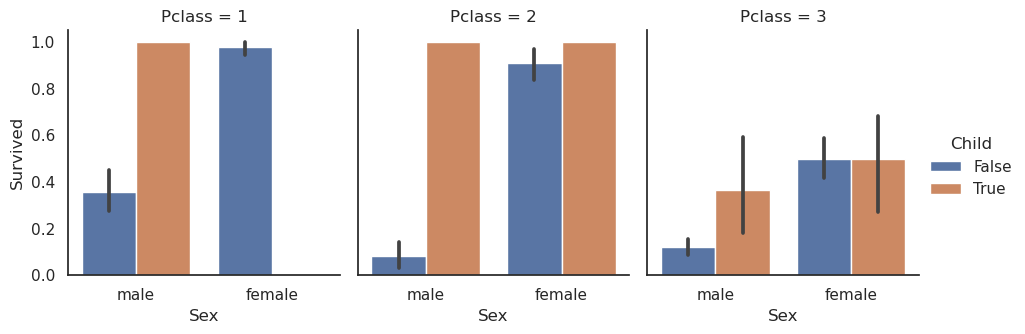

In [33]:
g = sns.catplot(x="Sex", y="Survived", hue="Child", col="Pclass",
                data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)
tab = pd.crosstab(train['Child'], train['Pclass'])
print(tab)
tab = pd.crosstab(train['Child'], train['Sex'])
print(tab)


The *Pclass == 1* plot looks interesting at first, but there are only 3 children in this group which makes the apparent pattern just random noise. The other two passenger classes are more interesting, especially for the male children. Note, that since we are selecting by *Age*, which has many missing values, a number of children will be in the *Child == False* group. Nonetheless, this seems useful.

**We learn:** Male children appear to have a survival advantage in 2nd and 3rd class. We should include the *Child* feature in our model testing.

### *Cabin\_known*

Survived       0    1
Cabin_known          
False        481  206
True          68  136


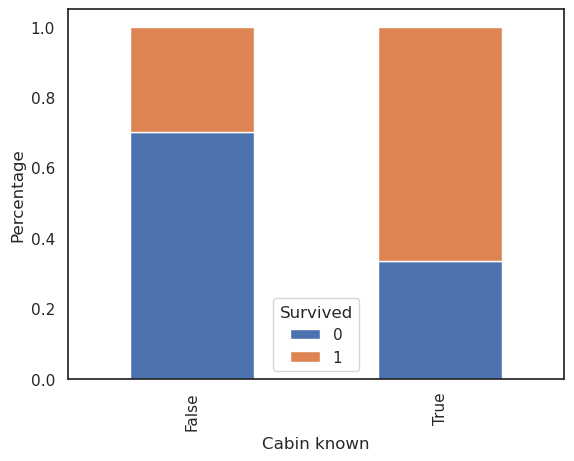

In [34]:
cab = pd.crosstab(train['Cabin_known'], train['Survived'])
print(cab)
dummy = cab.div(cab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Cabin known')
dummy = plt.ylabel('Percentage')

As suspected, it is more likely to know the cabin of a passenger who survived. This could be useful.

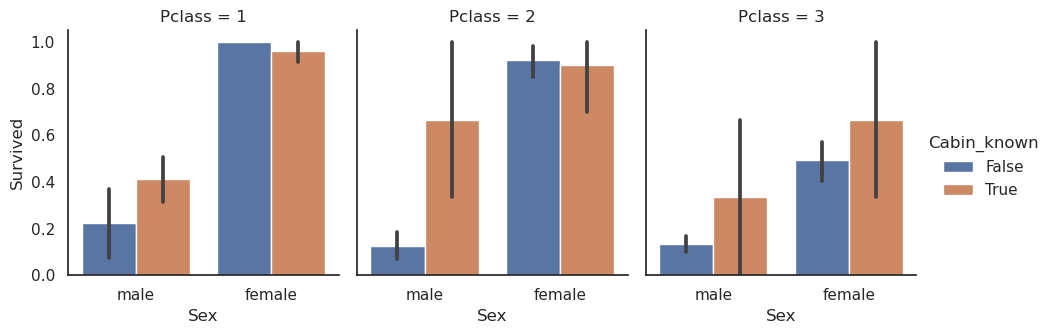

In [35]:
g = sns.catplot(x="Sex", y="Survived", hue="Cabin_known", col="Pclass",
                data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)

However, we see again that a large part of this effect disappears once we control for *Sex* and *Pclass*. 

**We learn:** There remains a potential trend for males and for 3rd class passengers but the uncertainties are large. This feature should be tested in the modelling stage.

### *Deck*

Survived    0    1
Deck              
A           8    7
B          12   35
C          24   35
D           8   25
E           8   24
F           5    8
G           2    2
T           1    0
U         481  206


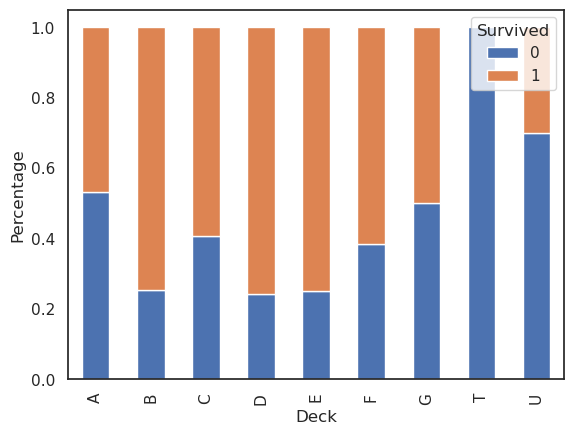

In [36]:
tab = pd.crosstab(train['Deck'], train['Survived'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Deck')
dummy = plt.ylabel('Percentage')

Ok, so what can we tell from the Deck (derived from the Cabin number)? First of all the overall survival statistics is much better than for the full sample, which is what we found above. Beyond that, the best decks for survival were B, D, and E with about 66% chance. C and F are around 60%. A and G at 50%. The only passenger on deck T died, but that's hardly robust statistics.

The largest number of cases we have is for B vs C. Let's see whether that's significant:

In [37]:
stats.binom_test(x=12,n=12+35,p=24/(24.+35.))

0.037415527401218285

Just about formally significant (i.e. < 5%). It might be worth our while to include this feature in at least the initial stages of modelling to see how it performs.

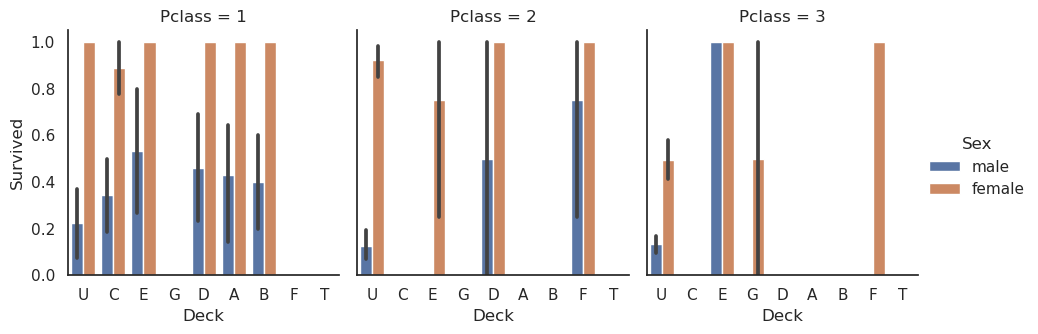

In [38]:
g = sns.catplot(x="Deck", y="Survived", hue="Sex", col="Pclass",
                data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)

In addition, there is some variation between the 1st class male passengers, but it doesn't look overly significant.

### *Ttype and Bad\_ticket*

Let's have a look at the ticket numbers and see whether we can extract some additional deck information from them. Above, we created a new feature called *Ttype* which defines the type of a ticket through the first digit of the ticket number.

In [39]:
print(train['Ttype'].unique())
print(test['Ttype'].unique())

['A' 'P' 'S' '1' '3' '2' 'C' '7' 'W' '4' 'F' 'L' '9' '6' '5' '8']
['3' '2' '7' 'A' '6' 'W' 'S' 'P' 'C' '1' 'F' '4' '9' 'L']


Survived    0   1
Ttype            
1          54  92
2          98  85
3         229  72
4           8   2
5           3   0
6           5   1
7           8   1
8           2   0
9           0   1
A          27   2
C          31  16
F           3   4
L           3   1
P          23  42
S          44  21
W          11   2


<AxesSubplot:xlabel='Ttype', ylabel='Survived'>

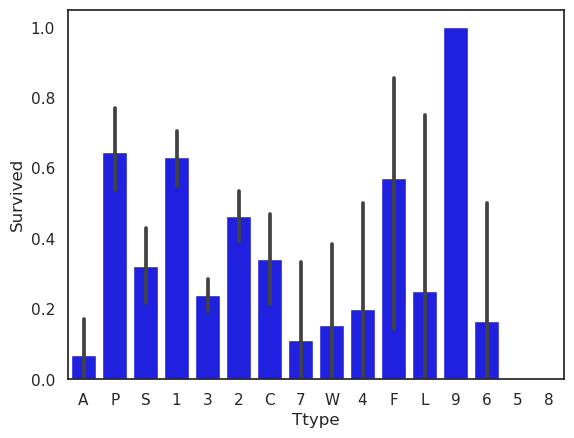

In [40]:
tab = pd.crosstab(train['Ttype'], train['Survived'])
print(tab)
sns.barplot(x="Ttype", y="Survived", data=train, ci=95.0, color="blue")

Based on this plot we define a new feature called *Bad\_ticket* under which we collect all the ticket numbers that start with digits which suggest less than 25% survival (e.g. *4*, *5*, or *A*). We are aware that some of the survival fractions we see above are based on small number statistics (e.g. 2 vs 0 for *8*). It is well possible that some of our "bad tickets" are merely statistical fluctuations from the base survival rate of 38%.  The barplot shows mean survival fractions and the associated 95% confidence limits, which are large for the sparse samples.

However, the significant difference between e.g. *1* and *3* (based on large enough numbers) suggests that this new feature could still contain some useful information. I think that without external information, which we are avoiding in this notebook, we can't do much better in trying to tie the ticket number to the survival statistics.

Of course, it's not the tickets themselves that are "bad" for survival, but the possibility that the ticket numbers might encode certain areas of the ship that would have led to higher or lower survival chances.

Survived      0    1
Bad_ticket          
False       253  261
True        296   81


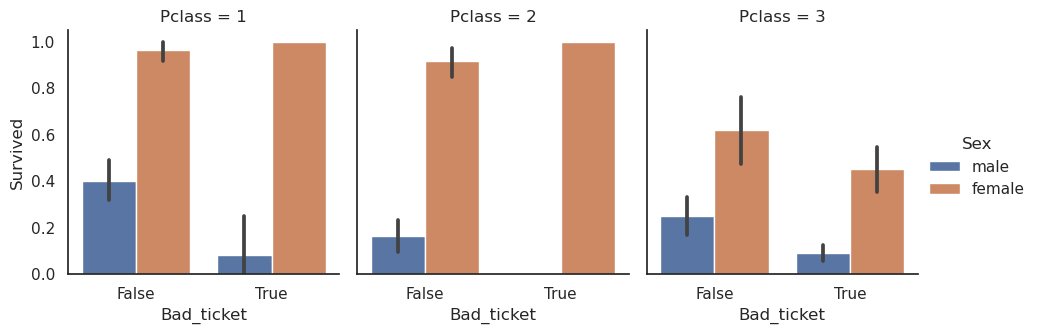

In [41]:
tab = pd.crosstab(train['Bad_ticket'], train['Survived'])
print(tab)
g = sns.catplot(x="Bad_ticket", y="Survived", hue="Sex", col="Pclass",
                data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)

The factorplot suggests that bad tickets are worse for male passengers, and 3rd class passengers. The individual significances are not overwhelming, but the trend itself might be useful.

Bad_ticket  False  True
Deck                   
A              14     1
B              44     3
C              56     3
D              24     9
E              27     5
F               9     4
G               2     2
T               1     0
U             337   350


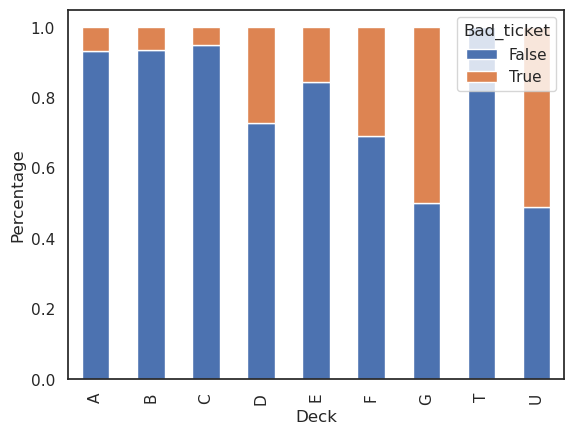

In [42]:
tab = pd.crosstab(train['Deck'], train['Bad_ticket'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Deck')
dummy = plt.ylabel('Percentage')

The last plot doesn't inspire much confidence in a strong correlation between *Deck* and *Bad\_ticket*, but maybe it will be useful otherwise.

**We learn:** *Bad\_ticket* might be a lower order effect that could give us some additional accuracy. We should test it out in the modelling stage.

### *Age\_known*

Similar to the known Cabin numbers, what about the *passengers for which we know the age*?

Survived     0    1
Age_known          
False      125   52
True       424  290


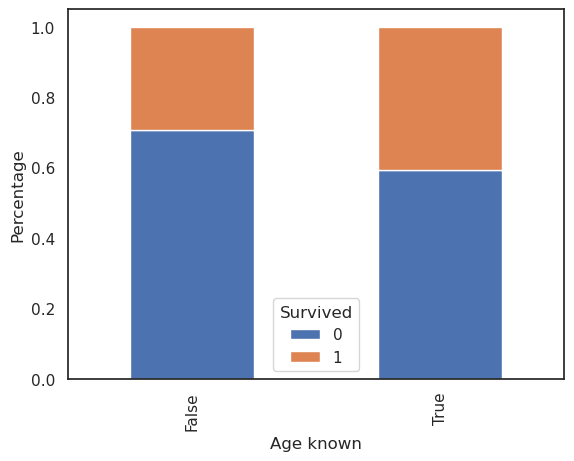

In [43]:
tab = pd.crosstab(train['Age_known'], train['Survived'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Age known')
dummy = plt.ylabel('Percentage')

As we would expect intuitively, it appears that we are more likely to know someones age if the survived the disaster. There's a difference of about 30% vs 40% and it should be significant:

In [44]:
stats.binom_test(x=424,n=424+290,p=125/(125.+52.))

1.5623264542201342e-10

Very much so. However, we have seen before that there might be imbalances in the dominating features *Sex* and *Plcass* that create an apparent signal. Is this another of these cases?

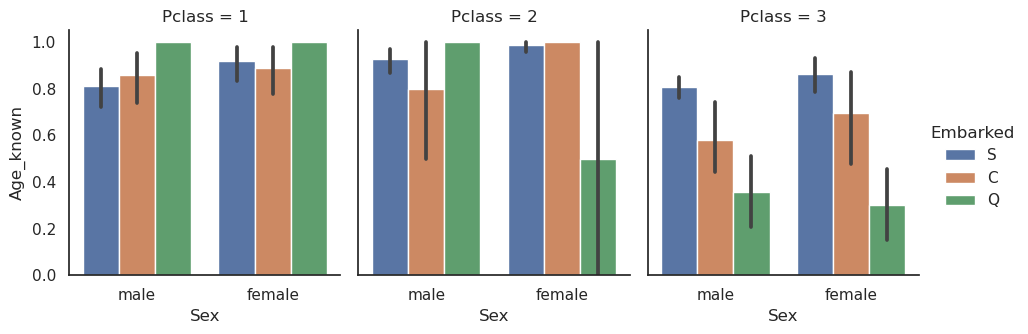

In [45]:
g = sns.catplot(x="Sex", y="Age_known", hue="Embarked", col="Pclass",
                data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)

It actually is. Turns out that we are more likely to know the age of higher class passengers or women, which are the strongest survival predictors we have found, so far. (Of course, the causality might as well go the other way, but that's not really the question here. What we want to find are the best predictors for survival.)

**We learn:** 
There is a strong impact of *Sex* and *Pclass* on this new feature. This might be enough to explain all the variance in the *Age\_known* variable. We should test the predictive power in our modelling.

### *Family*

Survived    0    1
Family            
0         374  163
1          72   89
2          43   59
3           8   21
4          12    3
5          19    3
6           8    4
7           6    0
10          7    0


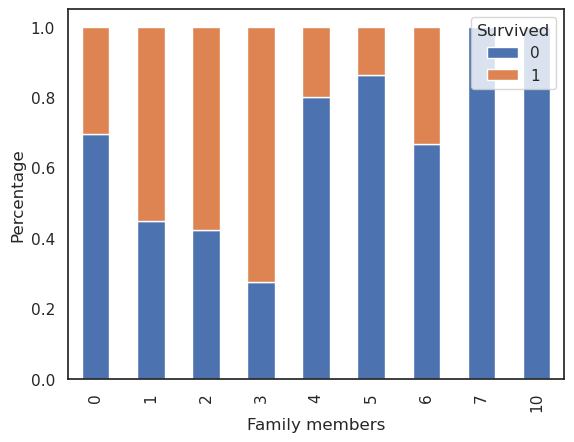

In [46]:
tab = pd.crosstab(train['Family'], train['Survived'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Family members')
dummy = plt.ylabel('Percentage')

**We learn:**
Again, we find that having 1-3 family members works best for survival. This feature is a mix of *SibSp* and *Parch*, which increases the overall numbers we can work with, but might smooth out some more subtle effects.

### *Alone*

Survived    0    1
Alone             
False     175  179
True      374  163


<AxesSubplot:xlabel='Alone', ylabel='Survived'>

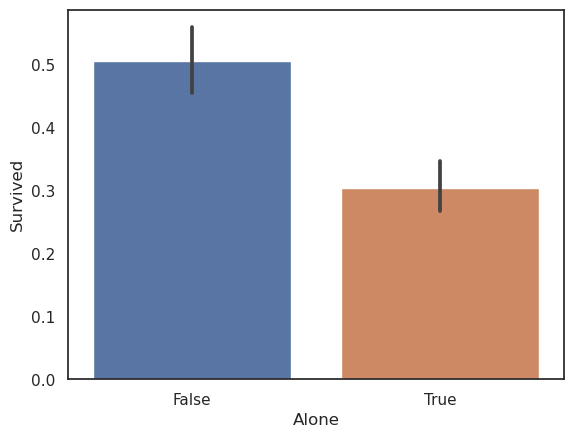

In [47]:
tab = pd.crosstab(train['Alone'], train['Survived'])
print(tab)
sns.barplot(x='Alone', y='Survived', data=train)

Travelling alone appears bad enough to be significant.

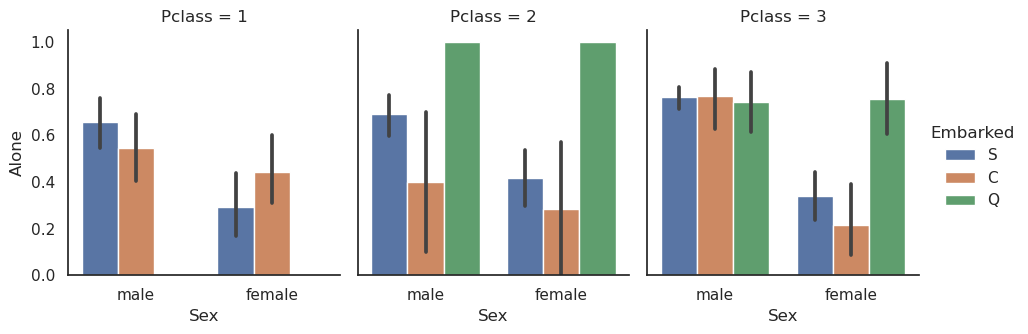

In [48]:
g = sns.catplot(x="Sex", y="Alone", hue="Embarked", col="Pclass",
                data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)


But more men were travelling alone than women did. Especially among the 3rd class passengers. Also this feature should be evaluated in our modelling step, to see if it's still significant in the presence of the *Sex* feature.

### *Large\_Family*

Survived        0    1
Large_Family          
False         501  334
True           48    8


<AxesSubplot:xlabel='Large_Family', ylabel='Survived'>

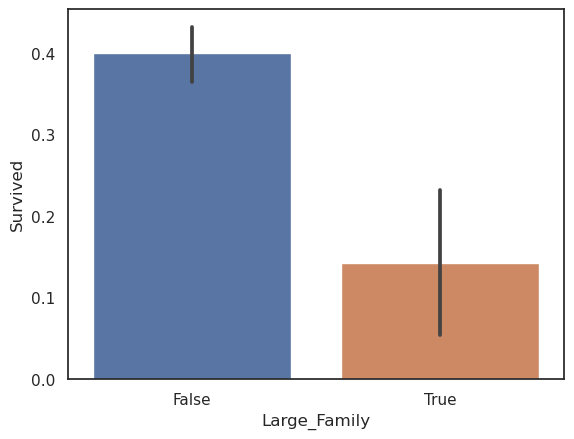

In [49]:
tab = pd.crosstab(train['Large_Family'], train['Survived'])
print(tab)
sns.barplot(x='Large_Family', y='Survived', data=train)

In the same way, having a large family appears to be not good for survival.

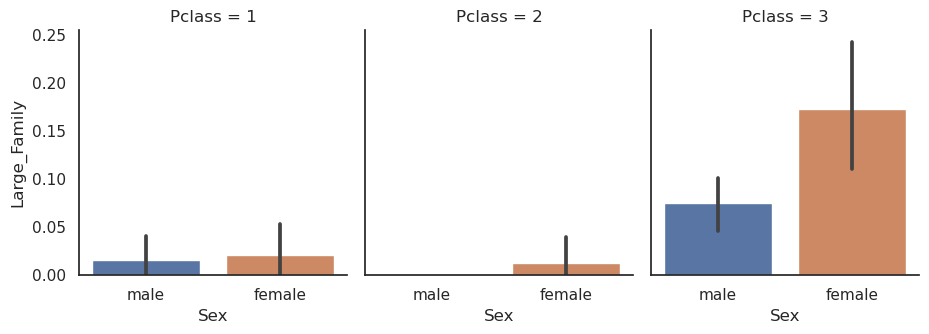

In [50]:
g = sns.catplot(x="Sex", y="Large_Family", col="Pclass",
                data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)

But most large families were travelling in 3rd class. The tentative imbalance between male and female 3rd class probably reflect the observation we made earlier that men were more likely to travel alone.

### *Shared\_ticket*

Survived         0    1
Shared_ticket          
0              351  130
1              198  212


<AxesSubplot:xlabel='Shared_ticket', ylabel='Survived'>

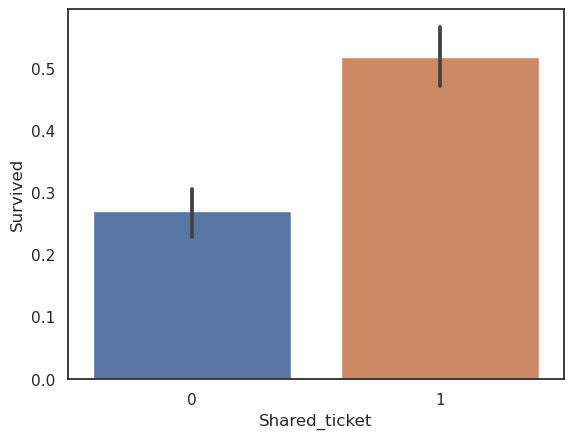

In [51]:
tab = pd.crosstab(train['Shared_ticket'], train['Survived'])
print(tab)
sns.barplot(x='Shared_ticket', y='Survived', data=train)

Sharing a ticket appears to be good for survival.

Sex            female  male
Shared_ticket              
0                 103   378
1                 211   199


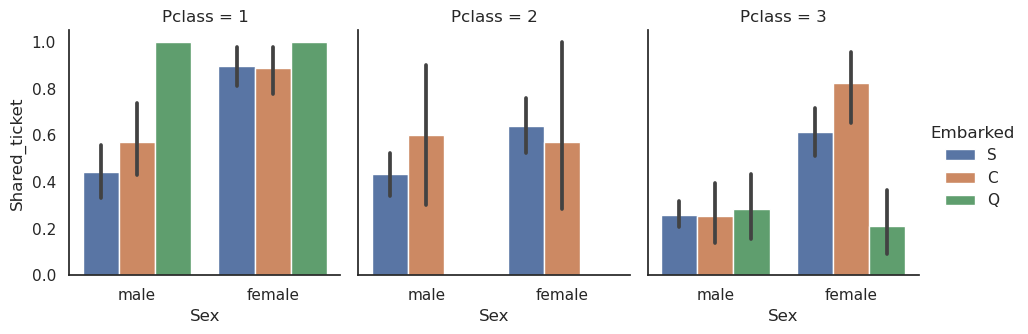

In [52]:
tab = pd.crosstab(train['Shared_ticket'], train['Sex'])
print(tab)
g = sns.catplot(x="Sex", y="Shared_ticket", hue="Embarked", col="Pclass",
                   data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)

But again the sharing of tickets is more frequent with females and 1st class passengers. This is consistent with the other statistics that show that women were more likely to travel together with larger families.

**We learn:** Several of these derived parameters are strongly correlated with *Sex* and *Pclass*. Whether there is actual signal in them that a model can use to improve the learning accuracy needs to be investigated.

### *Title*

What can we learn from the titles in the passenger names? What did we find in exercise 3?

 These could give us a direct, independent way to estimate the missing age values, so let's look at all the available titles, their frequency, and mean age. For this, we look at the *combined* data set to make sure that we don't miss any titles that might be in *train* or *test* only:

In [53]:
print(combine['Age'].groupby(combine['Title']).count())
print(combine['Age'].groupby(combine['Title']).mean())

print("There are %i unique titles in total."%(len(combine['Title'].unique())))

Title
Capt              1
Col               4
Don               1
Dona              1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           53
Miss            210
Mlle              2
Mme               1
Mr              581
Mrs             170
Ms                1
Rev               8
Sir               1
the Countess      1
Name: Age, dtype: int64
Title
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              43.571429
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           5.482642
Miss            21.774238
Mlle            24.000000
Mme             24.000000
Mr              32.252151
Mrs             36.994118
Ms              28.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64
There are 18 unique titles in total.


Ok, so we have 18 different titles, but many of them only apply to a handful of people. The dominating ones are Mr (581), Miss (210), Mrs (170), and Master (53); with the number referring to the combined data. Here are the age distributions for those:

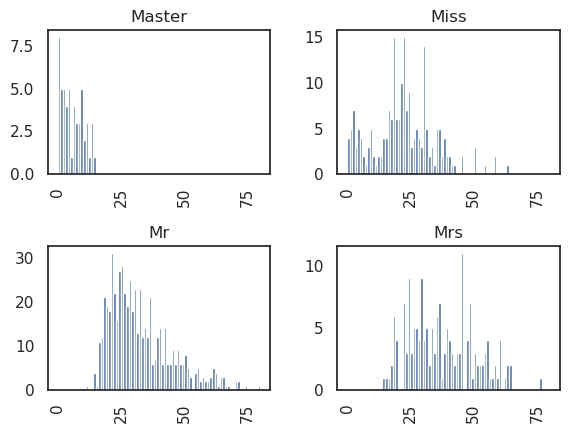

In [54]:
dummy = combine[combine['Title'].isin(['Mr','Miss','Mrs','Master'])]
foo = dummy['Age'].hist(by=dummy['Title'], bins=np.arange(0,81,1))

We see that *Master* is capturing the male children/teenagers very well, whereas *Miss* applies to girls as well as younger women up to about 40. *Mrs* does not contain many teenagers, but has a sizeable overlap with *Miss*; especially in the range of 20-30 years old.

Nevertheless, *Miss* is more likely to indicate a younger woman. Overall, there is a certain amount of variance and we're not going to be able to pinpoint a certain age based on the title.

Therefore, we will use 2 *Age Groups*, updating to the *Young* variable we defined above. The idea is to address the issue of missing *Age* values by combining the *Age* and *Title* features into a single feature that should still contain some of the signal regarding survival.

For this, we define everyone under 30 *or* with a title of *Master*, *Miss*, or *Mlle* (Mademoiselle) as *Young*. All the other titles we group into *Not Young*. This is a bit of a generalisation in terms of how *Miss* and *Mrs* overlap, but it might be a useful starting point. All the other rare titles (like *Don* or *Lady*) have average ages that are high enough to count as *Not Young*.

Survived    0    1
Young             
False     284  127
True      265  215


<AxesSubplot:xlabel='Young', ylabel='Survived'>

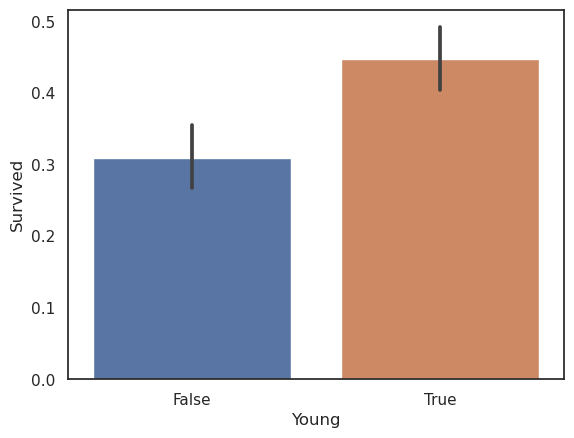

In [55]:
tab = pd.crosstab(train['Young'], train['Survived'])
print(tab)
sns.barplot(x='Young', y='Survived', data=train)

Finally, we model a fare category, *Fare_cat*, as an ordinal integer variable based on the logarithmic fare values:

Pclass    1    2    3
Young                
False   135   78  198
True     81  106  293


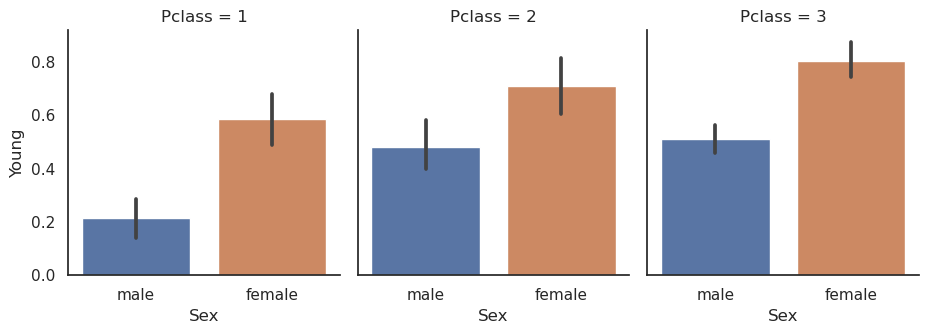

In [56]:
tab = pd.crosstab(train['Young'], train['Pclass'])
print(tab)
g = sns.catplot(x="Sex", y="Young", col="Pclass",
                   data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)

Because of the larger number of "Miss" vs "Master" mostly women are classified as "Young".  We also recover the age difference between the ticket classes that was already obvious in earlier plots. Both factors mean that the impact of *Young* has to be studied carefully.

### *Fare\_cat*

Let's remind ourselves of the distribution of *Fare* with respect to *Pclass*:

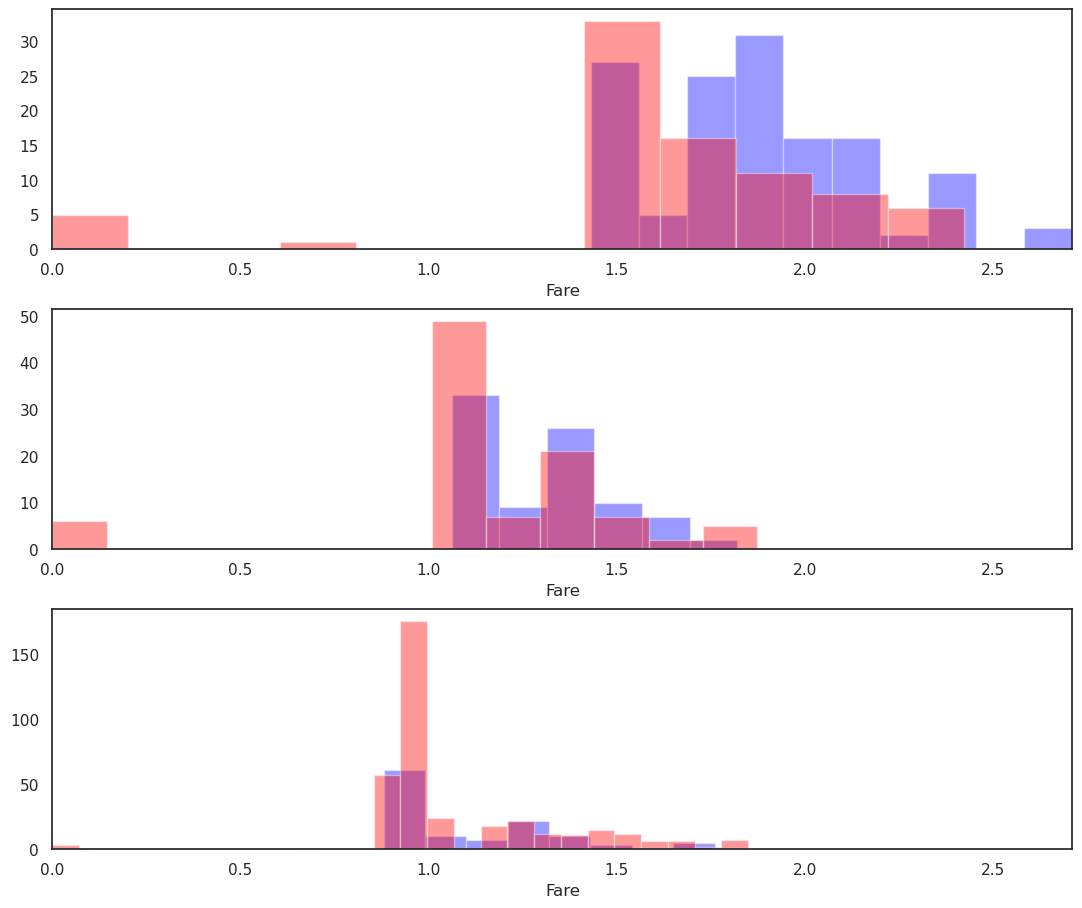

In [57]:
plt.figure(figsize=[12,10])
plt.subplot(311)
ax1 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==1].dropna().values+1), kde=False, color=surv_col)
ax1 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==1].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax1.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values+1)))
plt.subplot(312)
ax2 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==2].dropna().values+1), kde=False, color=surv_col)
ax2 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==2].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax2.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values+1)))
plt.subplot(313)
ax3 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==3].dropna().values+1), kde=False, color=surv_col)
ax3 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==3].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax3.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values+1)))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

To simplify this broad distribution, we decide to classify the fares into *3 fare categories*: 0-10, 10-100, and above 100. This transformation can be easily achieved using the base 10 logarithm:

In [58]:
pd.DataFrame(np.floor(np.log10(train['Fare'] + 1))).astype('int').head(5)

,Fare
0,0
1,1
2,0
3,1
4,0


The "+1" means that our boundaries are slightly shifted in terms of the "real" *Fare*. However, this shift avoids computing issues for the zero-fare passengers and it makes little difference for our understanding of the fare groups. In fact, in the plot above the offset had already been applied as well.

At the start of this section we define a new feature, *Fare\_cat*, as fare categories in the same way. Let's try it out:

Survived    0    1
Fare_cat          
0         249   62
1         286  241
2          14   39


<AxesSubplot:xlabel='Fare_cat', ylabel='Survived'>

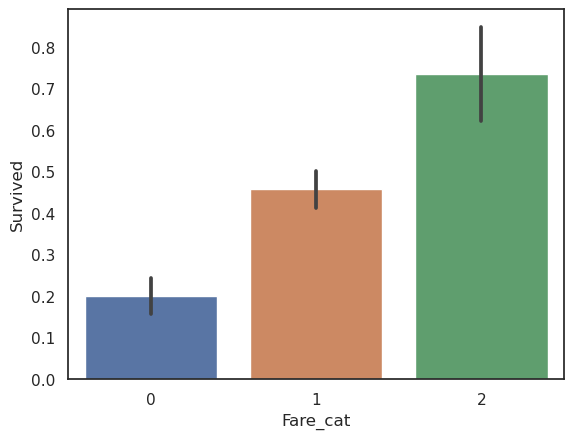

In [59]:
tab = pd.crosstab(train['Fare_cat'], train['Survived'])
print(tab)
sns.barplot(x='Fare_cat', y='Survived', data=train)

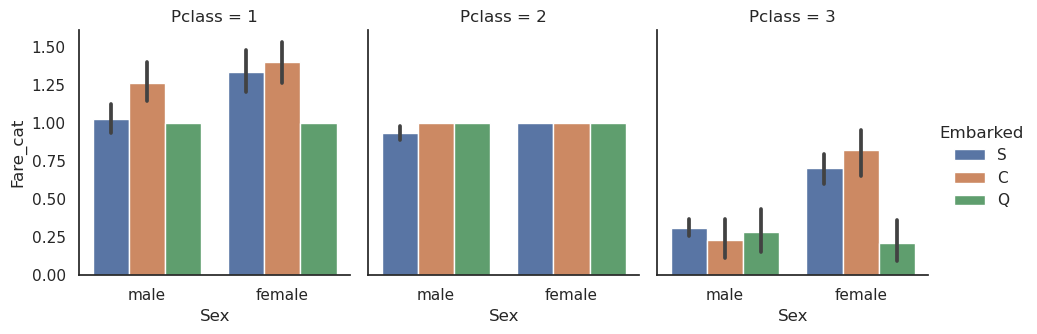

In [60]:
g = sns.catplot(x="Sex", y="Fare_cat", hue="Embarked", col="Pclass",
                   data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)

Our "usual" factorplot examination highlights the differences between *Pclass* (as expected) but also shows some interesting variations within the *Sex* feature. This might be related to the fact that women were more likely to share a cabin, and it would therefore indicate that the *Fare* might be a fare per cabin and not per passenger.

### *Fare\_eff\_cat*

Let's investigate the *Fare affair* in more detail. First, we make sure that the passengers in each group really had the same *Fare* values:

2

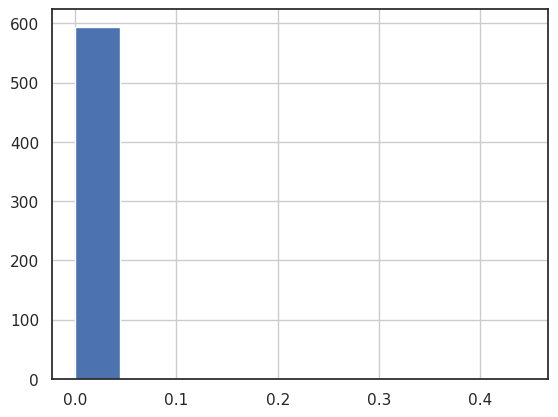

In [61]:
combine.groupby('Ticket')['Fare'].transform('std').hist()
np.sum(combine.groupby('Ticket')['Fare'].transform('std') > 0)

Almost 100% yes. Above, we extract the standard deviation of the *Fares* among the ticket groups. A standard deviation of zero means that there's no difference. Only 2 values stand out. This is a small number that we could ignore, but we are curious, aren't we?

In [62]:
combine.iloc[np.where(combine.groupby('Ticket')['Fare'].transform('std') > 0)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Deck,Ttype,Title,Fare_cat,Bad_ticket,Young,Shared_ticket,Ticket_group,Fare_eff,Fare_eff_cat
138,139,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,...,U,7,Mr,1,True,True,1,2,4.60835,0
876,877,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,...,U,7,Mr,1,True,True,1,2,4.92290,0


It's Mr Osen and Mr Gustafsson on Ticket 7534. Their *Fares* are close enough, though, to include them in the general treatment.

Now, let's think for a moment: Identical fares could mean that the fare for a cabin was shared equally among the passengers, in which case our previous treatment would have been justified. However, it *could* also mean that the listed value is the *cumulative fare per cabin* and it was simply recorded as the same value for each passenger. Intuitively, this doesn't seem so plausible, since you typically record what is paid for a ticket and not for a cabin. But let's investigate this for a moment and check how it would transform the *Fare* distribution. For this, we create a *Fare_eff* feature above, which we derive by dividing *Fare* by the number of people sharing a ticket (*Ticket_group*; which we also newly created).

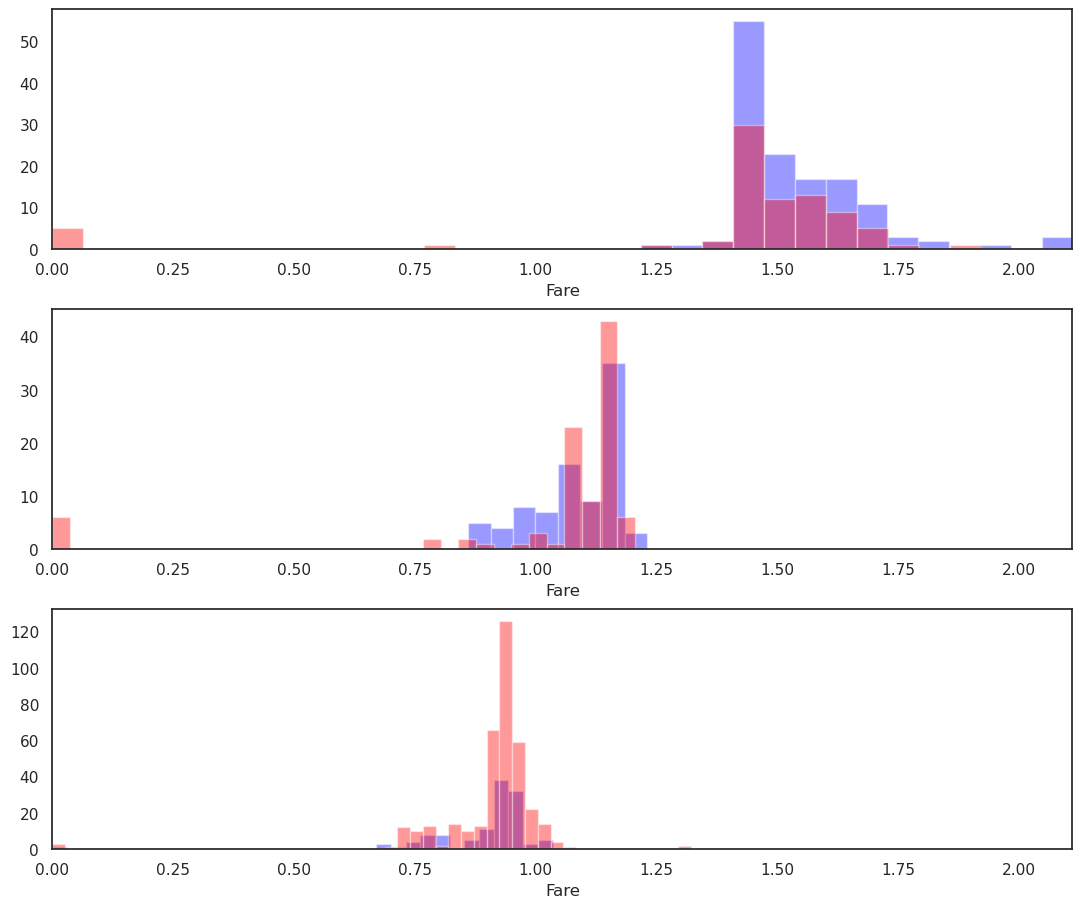

In [63]:
plt.figure(figsize=[12,10])
plt.subplot(311)
ax1 = sns.distplot(np.log10(surv['Fare_eff'][surv['Pclass']==1].dropna().values+1), kde=False, color=surv_col)
ax1 = sns.distplot(np.log10(nosurv['Fare_eff'][nosurv['Pclass']==1].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax1.set_xlim(0,np.max(np.log10(train['Fare_eff'].dropna().values+1)))
plt.subplot(312)
ax2 = sns.distplot(np.log10(surv['Fare_eff'][surv['Pclass']==2].dropna().values+1), kde=False, color=surv_col)
ax2 = sns.distplot(np.log10(nosurv['Fare_eff'][nosurv['Pclass']==2].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax2.set_xlim(0,np.max(np.log10(train['Fare_eff'].dropna().values+1)))
plt.subplot(313)
ax3 = sns.distplot(np.log10(surv['Fare_eff'][surv['Pclass']==3].dropna().values+1), kde=False, color=surv_col)
ax3 = sns.distplot(np.log10(nosurv['Fare_eff'][nosurv['Pclass']==3].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax3.set_xlim(0,np.max(np.log10(train['Fare_eff'].dropna().values+1)))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

Now **that** is interesting. We see that the distributions become significantly narrower and that the tails and bimodality become much weaker (after getting rid of the zero-fare values for both groups). The really expensive *Fares* in *Pclass == 1* are pretty much all gone. Here's how the standard deviations compare:

In [64]:
print(combine[combine['Fare']>1].groupby('Pclass')['Fare'].std())
print(combine[combine['Fare_eff']>1].groupby('Pclass')['Fare_eff'].std())

Pclass
1    80.259713
2    13.382064
3    11.476600
Name: Fare, dtype: float64
Pclass
1    14.675124
2     2.031927
3     1.366691
Name: Fare_eff, dtype: float64


We might even be at a stage now where we can investigate the few outliers more in detail:

In [65]:
combine[(combine['Pclass']==1) & (combine['Fare_eff']>0) & (combine['Fare_eff']<10)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Deck,Ttype,Title,Fare_cat,Bad_ticket,Young,Shared_ticket,Ticket_group,Fare_eff,Fare_eff_cat
872,873,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,...,B,6,Mr,0,True,False,0,1,5.0,0


That's really cheap for a 1st class cabin. Maybe a transcription error in the data itself?

In [66]:
combine[(combine['Pclass']==3) & (np.log10(combine['Fare_eff'])>1.2)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Deck,Ttype,Title,Fare_cat,Bad_ticket,Young,Shared_ticket,Ticket_group,Fare_eff,Fare_eff_cat
451,452,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,...,U,6,Mr,1,True,False,0,1,19.9667,2
490,491,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,...,U,6,Mr,1,True,False,0,1,19.9667,2


And that's quite expensive for a 3rd class ticket. Maybe these two actually shared a ticket / cabin and we have another transcription / data entry error? The ticket numbers are very similar and someone could easily write "303" instead of "304". Will we ever know? Maybe not. Does it matter much? Probably not.

More importantly, there is a reasonable argument to be made for this new *Fare_eff* feature to represent the actual fare better than the original feature. For once, it splits much cleaner between the *Pclasses*:

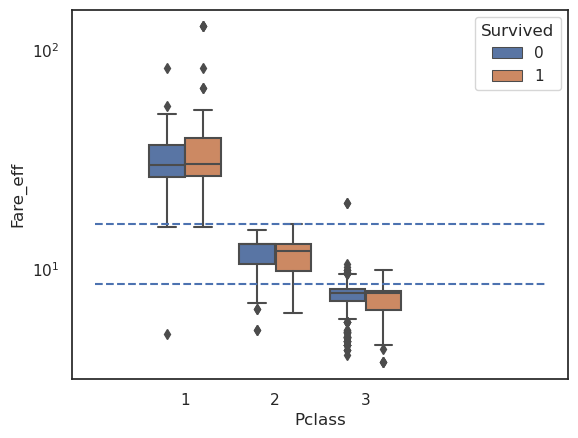

In [67]:
ax = sns.boxplot(x="Pclass", y="Fare_eff", hue="Survived", data=train)
ax.set_yscale('log')
ax.hlines([8.5,16],-1,4, linestyles='dashed')

So well, in fact that defining new fare categories seems almost redundant because *Pclass* already captures most of this signal. Nonetheless, we'll try; because we are optimistic people at heart. We use the dashed lines in the plot above for an (empirical) division into 3 classes, which separate the cheaper *Fare_eff* of a *Pclass* group from the more expensive ones of the next one. The new feature is called *Fare_eff_cat* and behaves as follows:

Survived        0    1
Fare_eff_cat          
0             346  120
1             128   87
2              75  135


<AxesSubplot:xlabel='Fare_eff_cat', ylabel='Survived'>

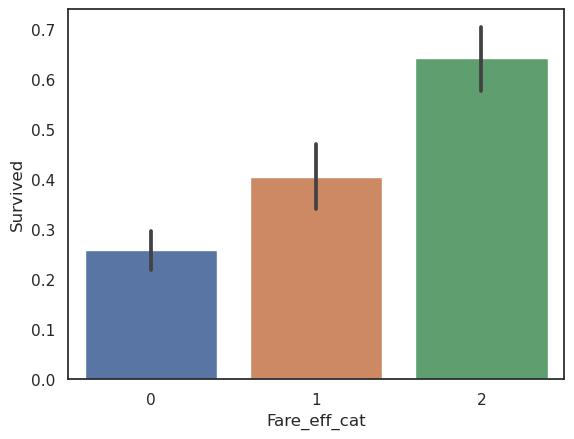

In [68]:
tab = pd.crosstab(train['Fare_eff_cat'], train['Survived'])
print(tab)
sns.barplot(x='Fare_eff_cat', y='Survived', data=train)

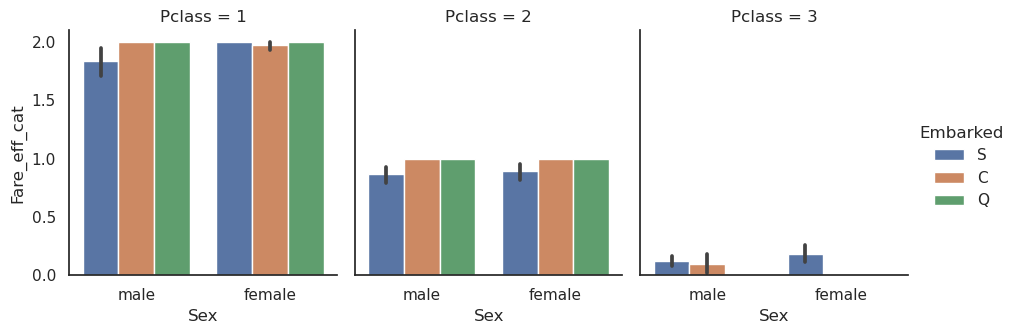

In [69]:
g = sns.catplot(x="Sex", y="Fare_eff_cat", hue="Embarked", col="Pclass",
                   data=train, aspect=0.9, height=3.5, kind="bar", ci=95.0)

<a id='encode'></a>

# 6. Preparing for modelling

Before we start exploring the different models we are modifying the categorical string column types to integer. This is necessary since not all classifiers can handle string input.

In [70]:
combine = pd.concat([train.drop('Survived',1),test])
survived = train['Survived']

combine["Sex"] = combine["Sex"].astype("category")
combine["Sex"].cat.categories = [0,1]
combine["Sex"] = combine["Sex"].astype("int")
combine["Embarked"] = combine["Embarked"].astype("category")
combine["Embarked"].cat.categories = [0,1,2]
combine["Embarked"] = combine["Embarked"].astype("int")
combine["Deck"] = combine["Deck"].astype("category")
combine["Deck"].cat.categories = [0,1,2,3,4,5,6,7,8]
combine["Deck"] = combine["Deck"].astype("int")

test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

train.loc[:,["Sex","Embarked"]].head()

,Sex,Embarked
0,1,2
1,0,0
2,0,2
3,0,2
4,1,2


For a final overview before the modelling stage we have another look at the correlation matrix between all old and new features:

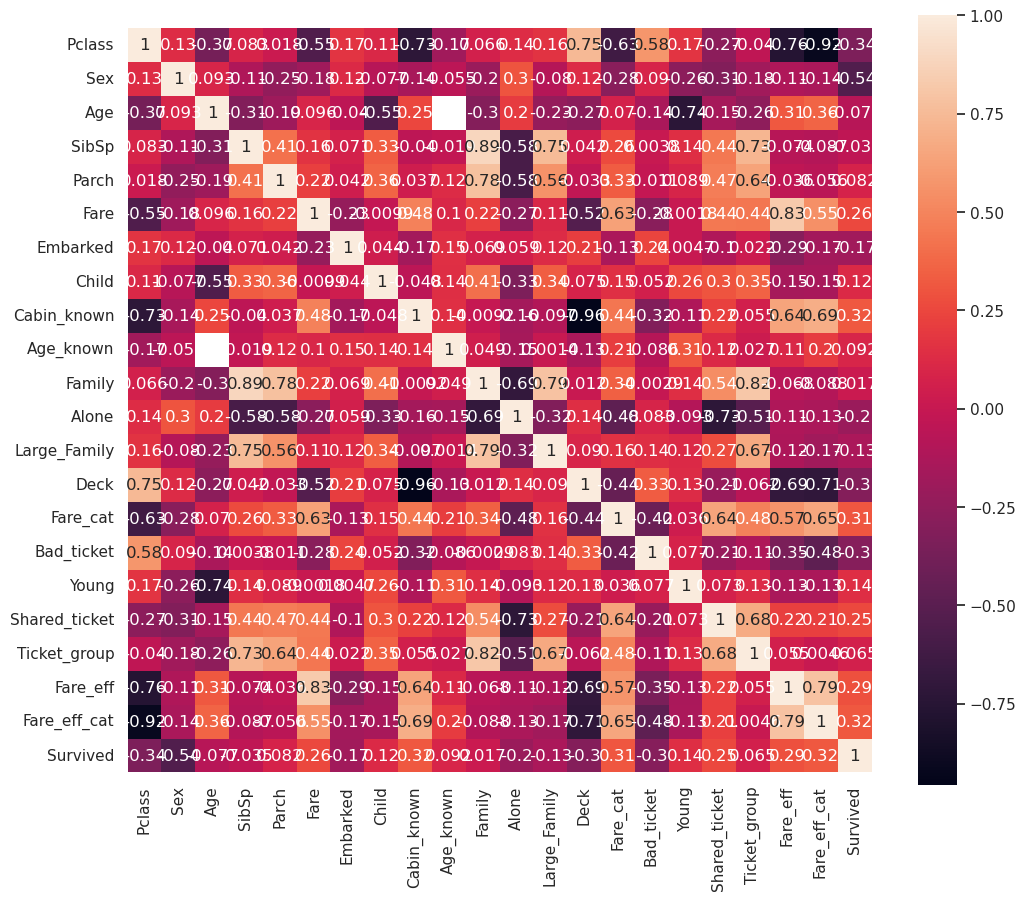

In [71]:
ax = plt.subplots( figsize =( 12 , 10 ) )
foo = sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=1.0, square=True, annot=True)

We designed a number of new features, and unsurprisingly several of those are correlated with the original features we used to create them. For instance *Fare\_cat* and *Fare*. Or *Family* and *SibSp/Parch*. In the modelling step, we will first determine which of the features carry the most signal (*to be done*) and then use them to train a number of different classifiers.

# 7. Modelling

Let's summarise briefly what we found in our data exploration:

- sex and ticket class are the main factors

- there seem to be additional impacts from:
    - age: young men vs young women; (male) children
    - relatives: parch = 1-3, sibsp = 1-2 (somewhat explained by sex but not completely)
    - maybe the cabin deck, but not many are known

- other apparent effects appear to be strongly connected to the sex/class features:
    - port of embarkation
    - fare
    - sharing a ticket
    - large family
    - travelling alone
    - known cabin number
    - known age

## *Splitting the train sample into two sub-samples: training and testing*

This is best practice for evaluating the performance of our models, which should not be tested on the same data they are trained on. This avoids overfitting. You can consider the 20% test_size as being the validation set.

In [72]:
training, testing = train_test_split(train, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(train.shape[0],training.shape[0],testing.shape[0]))

Total sample size = 891; training sample size = 712, testing sample size = 179


## *Test and select the model features*

Now we are ready to model. We start with a *Random Forest model* to assess the importance of the individual model features. We know that by definition some of our engineered features will have a *high collinearity* (i.e. behave similarly) with other new or existing features. For instance, *Young* was designed to replace *Age* and *Title* as a combination of the two. Other correlations are visible in the heatmap above. The initial modelling will allow us to decide which features are worth to take to the next step.

This is an iterative process in which you improve your model step by step, until you have found the largest feature combination which still has significant impact. Removing less important features will help you to reduce the noise in your prediction and allow your model to generalise to new data (which is our priority goal in machine learning.)


Based on the first look we define the input columns we'll be working with. We also create our training and testing feature sets.

In [73]:
# Here we decide on 10 features we want to choose initially
cols = ['Sex','Pclass','Cabin_known','Large_Family','Parch',
        'SibSp','Young','Alone','Shared_ticket','Child']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['Survived']])

### Random Forest Classifier

In [74]:
# Create a RandomForestClassifier with 100 estimators
clf_rf = RandomForestClassifier(n_estimators=100)

# Fit the classifier to the data
clf_rf = clf_rf.fit(X, y)

# Evaluate the classifier using cross-validation
score_rf = cross_val_score(clf_rf, X, y, cv=5).mean()

# Print the mean cross-validation score
print(score_rf)

0.7977149610952428


Models like Random Forests allow visualization of which features appear to play the most important role in splitting the data (e.g. into survived = 0/1)

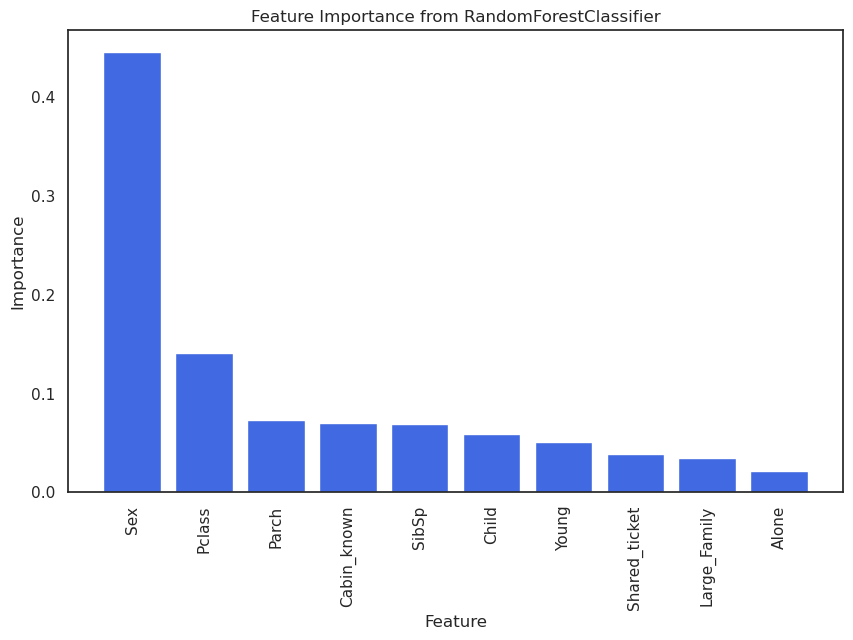

In [75]:
# Get the feature importances
importances = clf_rf.feature_importances_

# Sort the importances in descending order and their corresponding feature names
indices = np.argsort(importances)[::-1]
sorted_feature_names = [cols[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align='center', color='royalblue')
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance from RandomForestClassifier')
plt.show()

In [76]:
# We can then choose to keep certain features and run training again 
cols = ['Sex','Pclass','Cabin_known','Large_Family','Shared_ticket','Young','Alone','Child']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['Survived']])

df_test = testing.loc[:,tcols].dropna()
X_test = df_test.loc[:,cols]
y_test = np.ravel(df_test.loc[:,['Survived']])

clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf = clf_rf.fit(X, y)
score_rf = cross_val_score(clf_rf, X, y, cv=5).mean()
print(score_rf)

0.8174135723431497


# PCA

PCA (Principal Component Analysis) is a dimensionality reduction technique used in machine learning and data analysis to transform a dataset with many features into a new dataset with fewer features while retaining as much information as possible. PCA works by identifying the directions (principal components) in the original feature space along which the variance is maximized and projecting the data onto a lower-dimensional subspace defined by these principal components. This helps in reducing noise, improving computational efficiency, and visualizing high-dimensional data more easily.

Transformed data (PCA):
          0         1         2         3         4         5         6  \
0  1.071835  0.297872  0.188007 -2.192552 -0.180038  0.753540 -0.270590   
1 -1.543711 -0.448825  0.772024  0.060331  0.128943  0.417451  0.375727   
2  0.635008 -0.387575  1.430214 -1.097906 -0.896375 -0.353414  0.224752   
3 -1.505081  0.915814 -0.538908  0.505973 -0.176798 -0.567763 -0.155764   
4 -1.505081  0.915814 -0.538908  0.505973 -0.176798 -0.567763 -0.155764   

          7  
0  0.274331  
1 -0.510991  
2 -0.410115  
3  0.064605  
4  0.064605  

Explained variance ratio:
[0.30470567 0.24194253 0.13551241 0.10446667 0.08375634 0.06456775
 0.03652669 0.02852194]


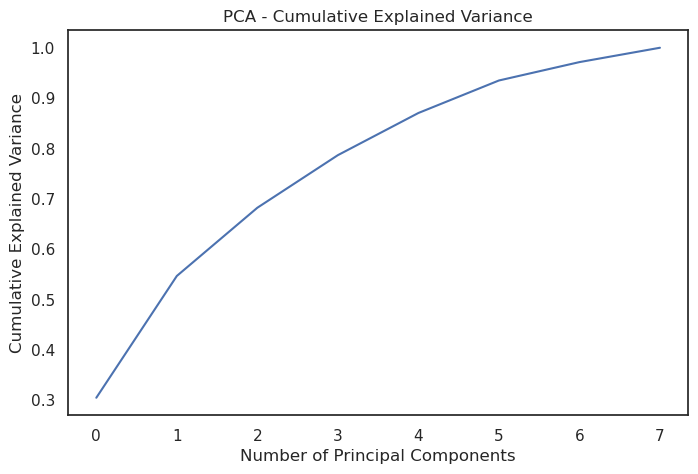

In [77]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the feature matrix (important step before PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Display the transformed data
print("Transformed data (PCA):")
print(pd.DataFrame(X_pca).head())

# Show the explained variance ratio for each principal component
print("\nExplained variance ratio:")
print(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.show()

The transformed data (PCA) represents the original data projected onto the new principal components. Each column in the transformed data corresponds to a principal component, and the values in the columns are the original data points transformed into the new coordinate system defined by the principal components. The transformed data helps you reduce dimensionality while retaining as much variance (information) as possible.

The explained variance ratio is an array that shows the proportion of the total variance in the dataset explained by each principal component. In our case, the first principal component (PC1) explains 30.47% of the total variance, the second principal component (PC2) explains 24.19%, and so on. The explained variance ratio helps you understand the importance of each principal component and decide how many of them to keep for further analysis.

To decide how many principal components to retain, you can look at the cumulative explained variance. Generally, you would want to keep enough principal components to explain a significant proportion (e.g., 80-95%) of the total variance in the dataset.

In our case, you can observe that with the first two principal components, you can explain about 54.66% (30.47% + 24.19%) of the total variance. You can choose the number of principal components to retain based on the cumulative explained variance and the specific requirements of your analysis.

Keep in mind that when you reduce the dimensionality using PCA, the transformed features will not have a direct interpretation in terms of the original features. They are linear combinations of the original features that capture the maximum variance in the dataset.

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Select the number of principal components to use (for example, the first two)
n_components = 2
X_pca_selected = X_pca[:, :n_components]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_selected, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = rf.predict(X_test)

# Evaluate the Random Forest model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[95  3]
 [20 25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89        98
           1       0.89      0.56      0.68        45

    accuracy                           0.84       143
   macro avg       0.86      0.76      0.79       143
weighted avg       0.85      0.84      0.83       143


Accuracy Score:
0.8391608391608392


# Exercise 4
Perform any type of feature engineering & hand picking (try choosing different input features, explore relationships between features, perform PCA, try choosing features based on feature importance, etc.) until you get your Random Forest model to >=86% accuracy.


In [86]:
# Write your code below
train.columns # columns you have available at the start

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Initial', 'Child',
       'Cabin_known', 'Age_known', 'Family', 'Alone', 'Large_Family', 'Deck',
       'Ttype', 'Title', 'Fare_cat', 'Bad_ticket', 'Young', 'Shared_ticket',
       'Ticket_group', 'Fare_eff', 'Fare_eff_cat', 'Survived'],
      dtype='object')

In [436]:
#cols = ['Sex','Pclass','Cabin_known','Large_Family','Shared_ticket','Young','Alone','Child']
cols = ['Sex','Pclass','Large_Family','Child']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['Survived']])

df_test = testing.loc[:,tcols].dropna()
X_test = df_test.loc[:,cols]
y_test = np.ravel(df_test.loc[:,['Survived']])

clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf = clf_rf.fit(X, y)
score_rf = cross_val_score(clf_rf, X, y, cv=5).mean()
print(score_rf) #0.828

0.825844577957254


In [434]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

n_components = 2
X_pca_selected = X_pca[:, :n_components]
X_train, X_test, y_train, y_test = train_test_split(X_pca_selected, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Accuracy Score:
0.8251748251748252
